In this notebook we will try to resolve Wine dataset problem with task description in 'Problem statement.pdf' file.
Firstly, let's import all neede libraries.

In [243]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import shapiro, f_oneway, kruskal, mannwhitneyu
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

# EDA

Load our data and see first examples.

In [244]:
data = pd.read_csv('WINE.csv')
data.head()

Index  Target        Type  Alcohol  Density  Nitrogen    pH  Sugar     A  \
0      0       3  white_wine     7.50     1.02      7.51  3.19  10.85  25.1   
1      1       4  white_wine     7.65     1.02      3.41  3.40   1.54  23.9   
2      2       3    red_wine     8.10     1.02      0.25  3.76   2.11  21.7   
3      3       4  white_wine     8.80     1.01      6.35  3.11   3.82  24.3   
4      4       3    red_wine     7.80     1.02      5.34  3.51   3.25  27.3   

      B     C     D     Di     E     H     S     U     V  
0  1.98  10.2  39.6  49.10  1.37  2.36  2.34  6.35  0.29  
1  1.58   4.2  38.5  48.16  0.94  2.42  3.07  7.65  0.05  
2  7.92   0.3  22.0  34.93  1.26  4.84  4.38  4.40  0.22  
3  1.45   4.2  16.5  33.77  1.01  1.49  8.18  3.60  0.10  
4  5.15   4.5  31.9  40.26  1.57  4.15  4.53  6.45  0.14

Let's see some info about our data.

In [245]:
print(data.info())
print(data.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Index     5600 non-null   int64  
 1   Target    5600 non-null   int64  
 2   Type      5600 non-null   object 
 3   Alcohol   5600 non-null   float64
 4   Density   5600 non-null   float64
 5   Nitrogen  5600 non-null   float64
 6   pH        5600 non-null   float64
 7   Sugar     5600 non-null   float64
 8   A         5567 non-null   float64
 9   B         5600 non-null   float64
 10  C         5600 non-null   float64
 11  D         5600 non-null   float64
 12  Di        5600 non-null   float64
 13  E         5600 non-null   float64
 14  H         5584 non-null   float64
 15  S         5600 non-null   float64
 16  U         5600 non-null   float64
 17  V         5600 non-null   float64
dtypes: float64(15), int64(2), object(1)
memory usage: 787.6+ KB
None
              Index       Target        Typ

Plot the target values distribution to know whether classes are balanced or not.

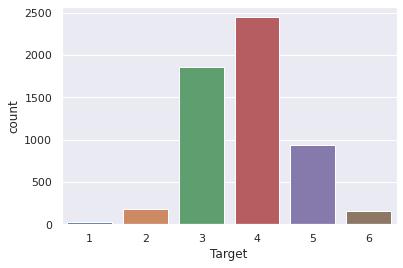

In [246]:
sns.countplot(x=data['Target']);

Plot box plots to see whether our features have outliers and which of them do.

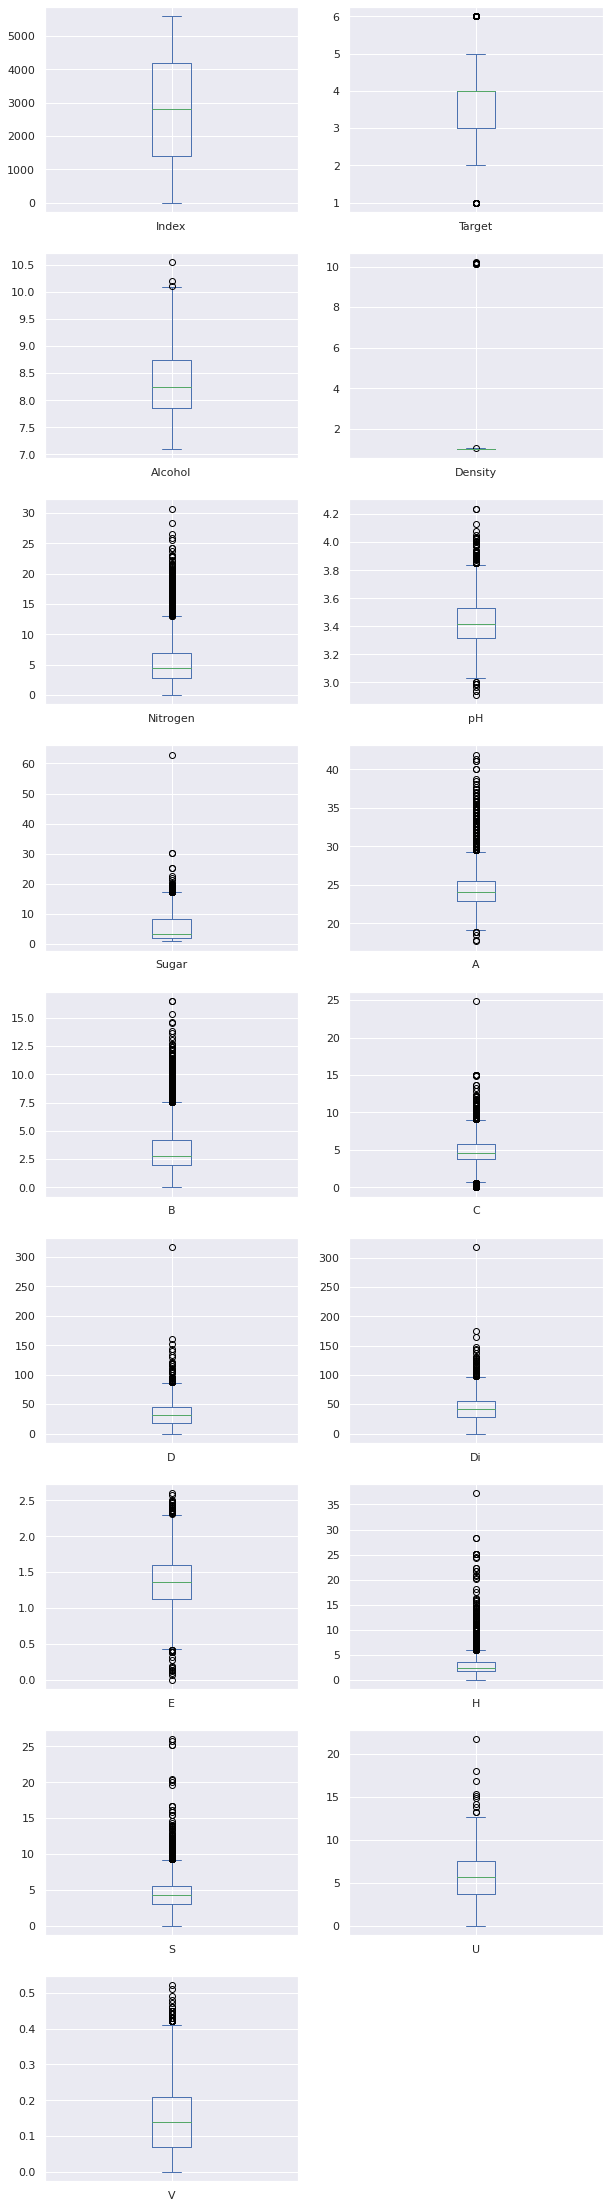

In [247]:
data.plot(kind='box', subplots=True, layout=(9, 2), figsize=(10, 40));

Boxplots by Target classes:

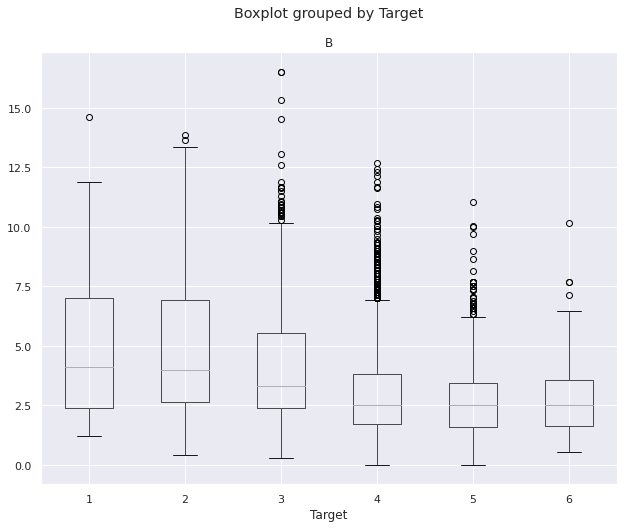

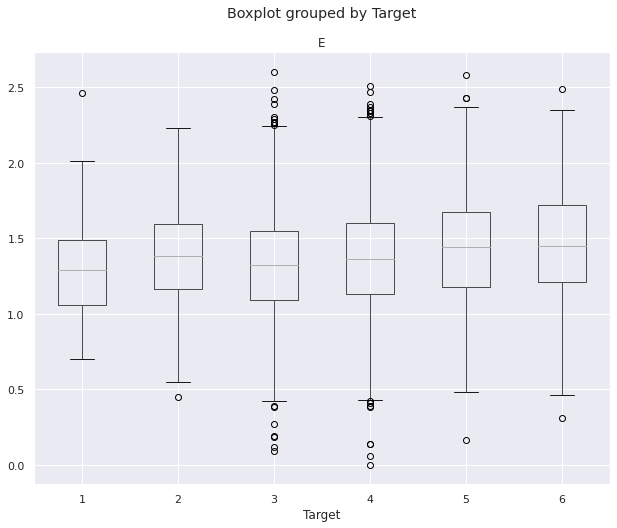

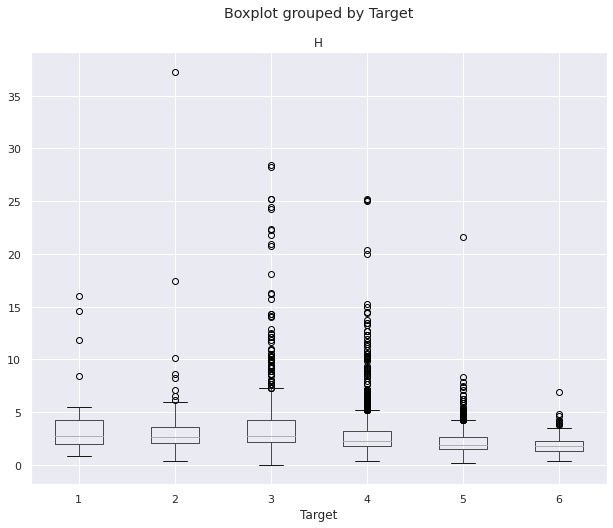

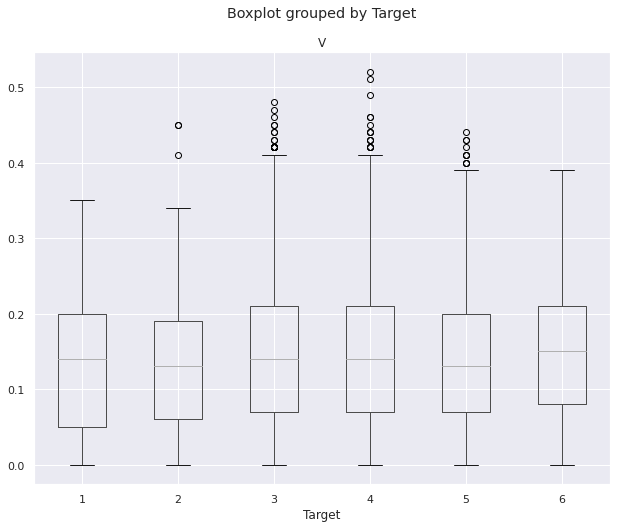

In [248]:
data.boxplot(['B'], by='Target', figsize=(10, 8));
data.boxplot(['E'], by='Target', figsize=(10, 8));
data.boxplot(['H'], by='Target', figsize=(10, 8));
data.boxplot(['V'], by='Target', figsize=(10, 8));


As we can see from the barplot above, all of the features have outliers (apart from 'Index' obviously) but it is hard to estimate their amount. We can only roughly say that there are features that have not many outliers: 'Alcohol', 'Density' and 'U'.
We can try out to remove outliers by 2nd and 98th percentiles.
Also we hardly can see features distribution so it would be better to plot it in the next step.

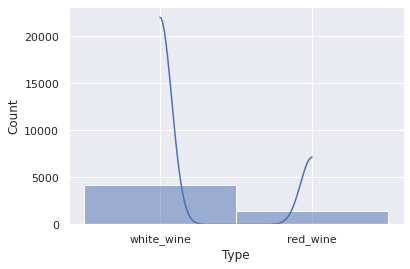

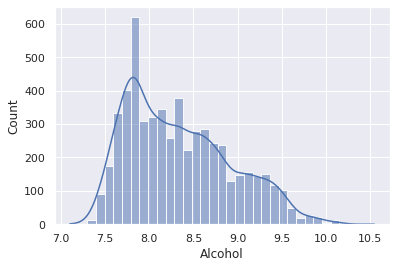

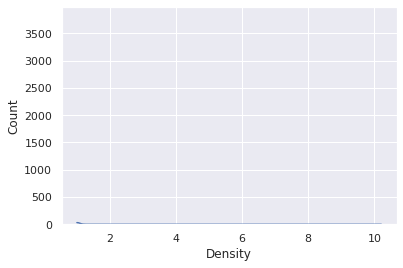

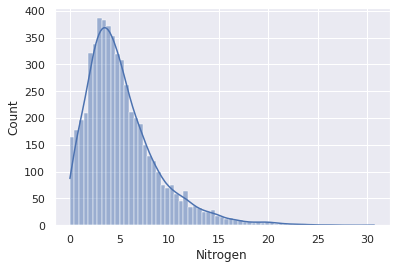

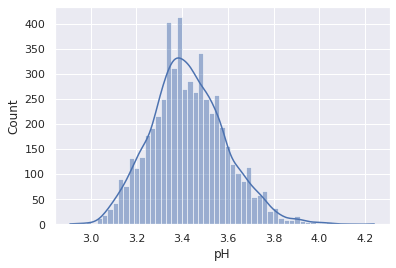

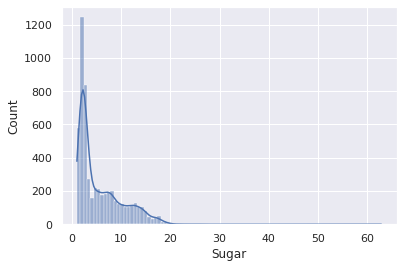

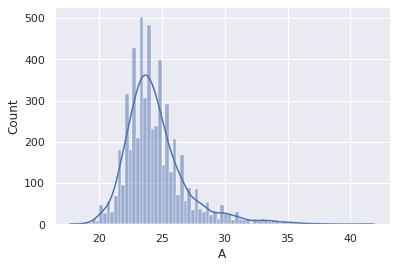

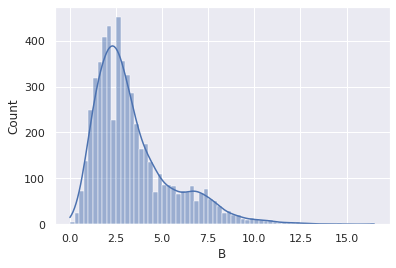

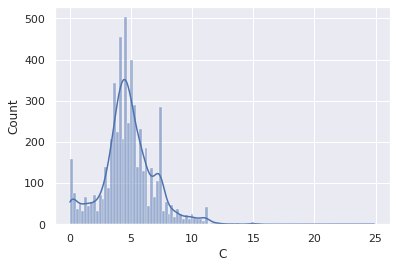

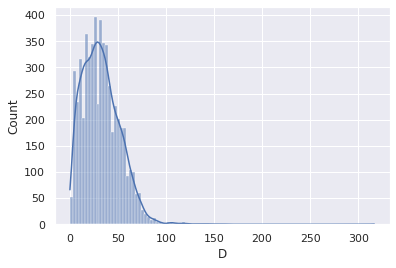

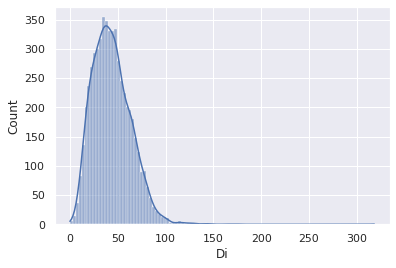

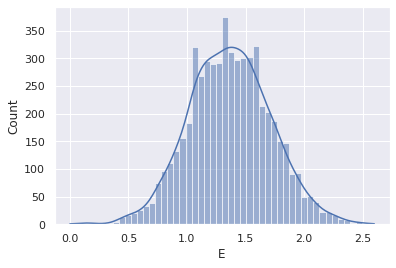

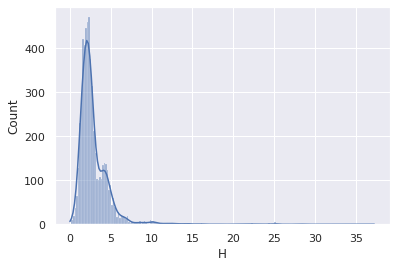

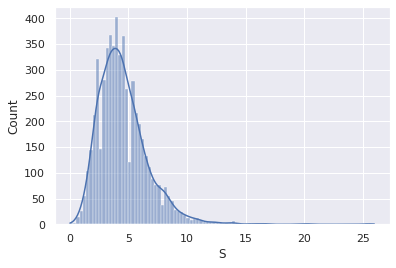

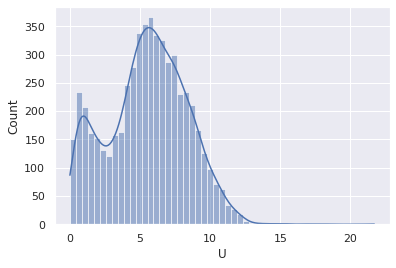

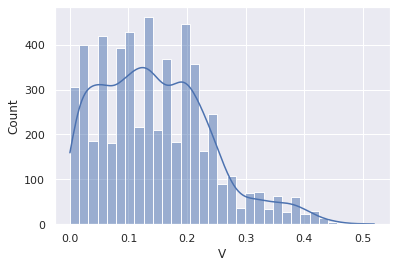

In [249]:
# do not include 'Index' and 'Target' columns
for feature in data.columns[2:]:
    plt.figure()
    sns.histplot(data, x=feature, kde=True)

KDEs by Target classes:

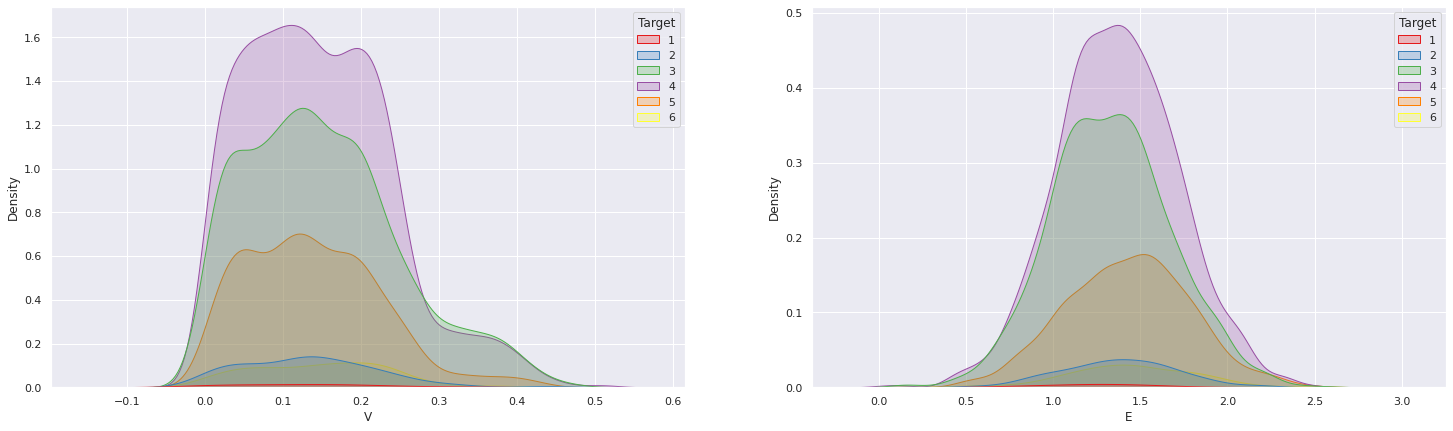

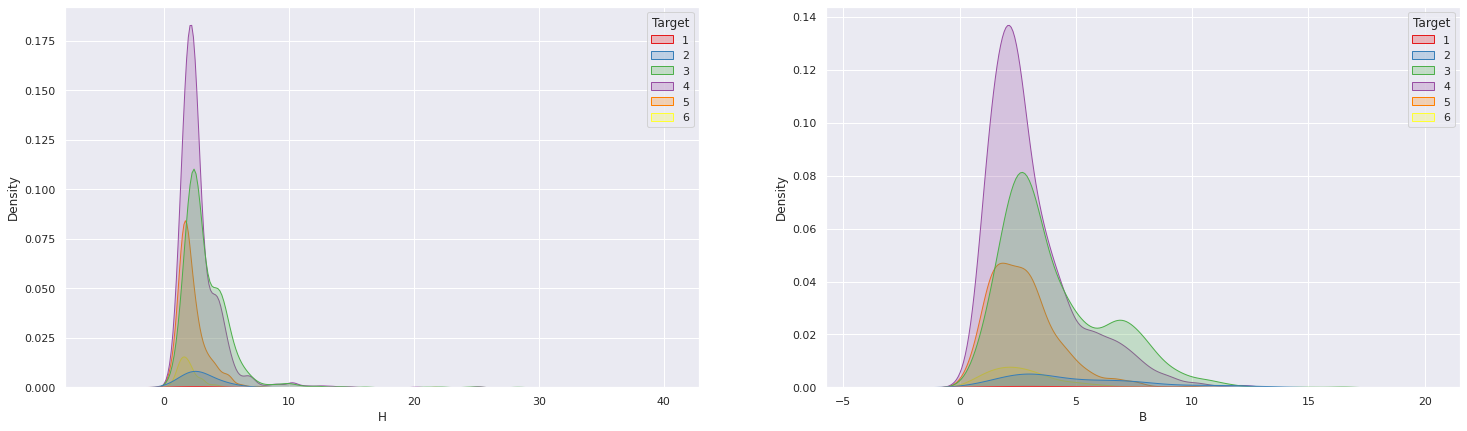

In [250]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 7))
sns.kdeplot(data=data, x='V', hue='Target', palette='Set1', cbar_kws={'lw': 10}, shade=True, ax=ax1)
sns.kdeplot(data=data, x='E', hue='Target', palette='Set1', cbar_kws={'lw': 10}, shade=True, ax=ax2)
plt.show()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 7))
sns.kdeplot(data=data, x='H', hue='Target', palette='Set1', cbar_kws={'lw': 10}, shade=True, ax=ax1)
sns.kdeplot(data=data, x='B', hue='Target', palette='Set1', cbar_kws={'lw': 10}, shade=True, ax=ax2)
plt.show()


We did not get much information from 'Density' feature distribution plot so we try a slightly different approcah: countplot.

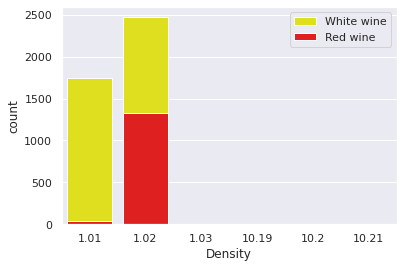

In [251]:
s1 = sns.countplot(x=data[data['Type'] == 'white_wine']["Density"], color='yellow');
s2 = sns.countplot(x=data[data['Type'] == 'red_wine']["Density"], color='red');
plt.legend(labels=['White wine', 'Red wine']);

Do the train/validation split.

In [252]:
x = data.iloc[:, 2:]
y = data.iloc[:, 1]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, stratify=y)

data_train = x_train
data_train.insert(0, 'Target', y_train)
data_val = x_val
data_val.insert(0, 'Target', y_val)

## Outliers handling: clamping and median

Get rid of the outliers. Define threshold as 2% so we took out data below 2 percentile and above 98 percentile.
I don't touch 'Type' and 'Density' columns: first of them is categorical and second seems to have values entered erroneously (they are way bigger) and taking out 4% of values will drop all outliers, of course, but also valid values with them.
For 'Density' it will be better to manually find anomalies and cut out just them.

Also it is a good question what to do with rows with outliers: delete them, replace with median or clamp using some min/max values.

I will not provide the code for the first approach because it has no sense, but just deleting rows with outliers cuts off almost 50% of the dataset which is unacceptable.
So I try to replace outliers with median value and clamp them. Let's define the same 2nd and 98th percentiles as threshold for clamping.

I will use variable **'data_no_outliers_clamp'** for clamped dataset and **'data_no_outliers_median'** for data with outliers replaced with median.

In [253]:
# define low and hight percentiles
percentile_low = 0.02
percentile_high = 0.98

# we don't need 'Index' and 'Target' columns at all, as to 'Type' and 'Destiny' it is said above
data_no_outliers_clamp = data_train.drop(['Target', 'Type', 'Density'], axis=1)

# do clamping
for column in data_no_outliers_clamp:
    data_no_outliers_clamp[column] = data_no_outliers_clamp[column].clip(data_no_outliers_clamp[column].quantile(percentile_low), 
                                data_no_outliers_clamp[column].quantile(percentile_high), axis=0)
print(data_no_outliers_clamp.describe())

# return 'Type' and 'Target' columns
data_no_outliers_clamp.insert(1, 'Density', data_train.loc[:, 'Density'])
data_no_outliers_clamp.insert(0, 'Type', data_train.loc[:, 'Type'])
data_no_outliers_clamp.insert(0, 'Target', data_train.loc[:, 'Target'])

# replace all mistakenly added values of 'Density' with median and most popular class for the 'Type' column
data_no_outliers_clamp.loc[data_no_outliers_clamp['Density'] > 2, 'Density'] = data_no_outliers_clamp.loc[:, 'Density'].median()

# replace NaNs with median value of the column
if data_no_outliers_clamp.isnull().values.any():
    data_no_outliers_clamp.iloc[:, 2] = data_no_outliers_clamp.iloc[:, 2].fillna('white_wine')
    data_no_outliers_clamp.iloc[:, 3:] = data_no_outliers_clamp.iloc[:, 3:].fillna(data_no_outliers_clamp.iloc[:, 3:].median())

# check whether there are no NaNs left
print('Are there any NaNs?', data_no_outliers_clamp.isnull().values.any())

data_no_outliers_clamp.info()
data_no_outliers_clamp.describe()

           Alcohol     Nitrogen           pH        Sugar            A  \
count  4480.000000  4480.000000  4480.000000  4480.000000  4454.000000   
mean      8.338170     5.175225     3.425978     5.586719    24.541338   
std       0.580022     3.459166     0.159013     4.392566     2.418954   
min       7.500000     0.305800     3.120000     1.350000    20.700000   
25%       7.850000     2.760000     3.320000     2.110000    22.900000   
50%       8.250000     4.450000     3.420000     3.340000    24.100000   
75%       8.750000     6.800000     3.530000     8.190000    25.500000   
max       9.600000    15.868400     3.800000    16.830000    32.688000   

                 B            C            D           Di            E  \
count  4480.000000  4480.000000  4480.000000  4480.000000  4480.000000   
mean      3.394757     4.777165    32.297400    43.471587     1.370603   
std       2.045090     2.099704    18.307704    18.969408     0.335872   
min       0.790000     0.000000     4

Target      Alcohol      Density     Nitrogen           pH  \
count  4480.000000  4480.000000  4480.000000  4480.000000  4480.000000   
mean      3.812054     8.338170     1.016844     5.175225     3.425978   
std       0.863767     0.580022     0.004724     3.459166     0.159013   
min       1.000000     7.500000     1.010000     0.305800     3.120000   
25%       3.000000     7.850000     1.010000     2.760000     3.320000   
50%       4.000000     8.250000     1.020000     4.450000     3.420000   
75%       4.000000     8.750000     1.020000     6.800000     3.530000   
max       6.000000     9.600000     1.060000    15.868400     3.800000   

             Sugar            A            B            C            D  \
count  4480.000000  4480.000000  4480.000000  4480.000000  4480.000000   
mean      5.586719    24.538777     3.394757     4.777165    32.297400   
std       4.392566     2.412156     2.045090     2.099704    18.307704   
min       1.350000    20.700000     0.790000     0.000000     4.400000   
25%       2.110000    22.900000     1.980000     3.750000    17.600000   
50%       3.340000    24.100000     2.770000     4.650000    30.800000   
75%       8.190000    25.500000     4.220000     5.850000    45.100000   
max      16.830000    32.688000     9.240000    10.200000    74.800000   

                Di            E            H            S            U  \
count  4480.000000  4480.000000  4480.000000  4480.000000  4480.000000   
mean     43.471587     1.370603     2.820547     4.519147     5.518210   
std      18.969408     0.335872     1.529145     1.941563     2.755462   
min      11.320000     0.660000     0.930000     1.460000     0.350000   
25%      28.645000     1.130000     1.800000     3.070000     3.700000   
50%      41.610000     1.370000     2.360000     4.230000     5.650000   
75%      56.192500     1.600000     3.470000     5.550000     7.550000   
max      88.296200     2.100000     8.490000     9.930000    10.900000   

                 V  
count  4480.000000  
mean      0.145129  
std       0.092516  
min       0.010000  
25%       0.070000  
50%       0.140000  
75%       0.210000  
max       0.380000

Now I replace all outliers with median values of the corresponding columns.

In [254]:
# we don't need 'Index' and 'Target' columns at all, as to 'Type' and 'Destiny' it is said above
data_no_outliers = data_train.drop(['Target', 'Type', 'Density'], axis=1)

percentile_data = data_no_outliers.quantile([percentile_low, percentile_high])

# drop outliers by percentiles
data_no_outliers = data_no_outliers.apply(lambda x: x[(x > percentile_data.loc[percentile_low, x.name]) & 
                                                    (x < percentile_data.loc[percentile_high, x.name])], axis=0)

# return 'Type' and 'Target' columns
data_no_outliers.insert(1, 'Density', data_train.loc[:, 'Density'])
data_no_outliers.insert(0, 'Type', data_train.loc[:, 'Type'])
data_no_outliers.insert(0, 'Target', data_train.loc[:, 'Target'])                                                    

data_no_outliers_median = data_no_outliers.copy()

# there are NaNs where was outliers so replace them with median and most popular class for the 'Type' column
data_no_outliers_median.iloc[:, 1] = data_no_outliers_median.iloc[:, 1].fillna('white_wine')
data_no_outliers_median.iloc[:, 2:] = data_no_outliers_median.iloc[:, 2:].fillna(data_no_outliers_median.median())

# clean up 'Density' separately
data_no_outliers_median.loc[data_no_outliers_median['Density'] > 2, 'Density'] = data_no_outliers_median.loc[:, 'Density'].median()

# check whether there are no NaNs left
print('Are there any NaNs?', data_no_outliers_median.isnull().values.any())

data_no_outliers_median.info()
data_no_outliers_median.describe()

Are there any NaNs? False
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4480 entries, 0 to 5599
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Target    4480 non-null   int64  
 1   Type      4480 non-null   object 
 2   Alcohol   4480 non-null   float64
 3   Density   4480 non-null   float64
 4   Nitrogen  4480 non-null   float64
 5   pH        4480 non-null   float64
 6   Sugar     4480 non-null   float64
 7   A         4480 non-null   float64
 8   B         4480 non-null   float64
 9   C         4480 non-null   float64
 10  D         4480 non-null   float64
 11  Di        4480 non-null   float64
 12  E         4480 non-null   float64
 13  H         4480 non-null   float64
 14  S         4480 non-null   float64
 15  U         4480 non-null   float64
 16  V         4480 non-null   float64
dtypes: float64(15), int64(1), object(1)
memory usage: 630.0+ KB


<ipython-input-254-615a6bb89a9c>:19: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_no_outliers_median.iloc[:, 2:] = data_no_outliers_median.iloc[:, 2:].fillna(data_no_outliers_median.median())


Target      Alcohol      Density     Nitrogen           pH  \
count  4480.000000  4480.000000  4480.000000  4480.000000  4480.000000   
mean      3.812054     8.332578     1.016844     5.029092     3.425138   
std       0.863767     0.522700     0.004724     3.031757     0.142263   
min       1.000000     7.550000     1.010000     0.310000     3.130000   
25%       3.000000     7.850000     1.010000     2.880000     3.330000   
50%       4.000000     8.250000     1.020000     4.450000     3.420000   
75%       4.000000     8.700000     1.020000     6.550000     3.520000   
max       6.000000     9.550000     1.060000    15.860000     3.790000   

             Sugar            A            B            C            D  \
count  4480.000000  4480.000000  4480.000000  4480.000000  4480.000000   
mean      5.351850    24.443661     3.315692     4.765547    32.277757   
std       4.031146     2.036588     1.815588     1.810400    16.306419   
min       1.400000    20.900000     0.860000     0.150000     5.500000   
25%       2.210000    23.100000     1.980000     3.900000    19.800000   
50%       3.440000    24.100000     2.770000     4.650000    30.800000   
75%       7.810000    25.300000     4.090000     5.700000    42.900000   
max      16.740000    32.500000     9.170000    10.050000    73.700000   

                Di            E            H            S            U  \
count  4480.000000  4480.000000  4480.000000  4480.000000  4480.000000   
mean     43.149364     1.370025     2.729228     4.465529     5.520420   
std      17.277083     0.301926     1.266153     1.696833     2.538456   
min      11.370000     0.670000     0.990000     1.610000     0.400000   
25%      29.937500     1.150000     1.860000     3.210000     4.000000   
50%      41.620000     1.370000     2.360000     4.230000     5.650000   
75%      54.785000     1.580000     3.290000     5.400000     7.350000   
max      88.250000     2.090000     8.430000     9.780000    10.850000   

                 V  
count  4480.000000  
mean      0.146507  
std       0.079010  
min       0.020000  
25%       0.090000  
50%       0.140000  
75%       0.200000  
max       0.370000

Let's see what we got after outliers replacing.

Below we can compare 'D' and 'Di' dependency on the raw data, after deleting outliers and after replacing them with median.

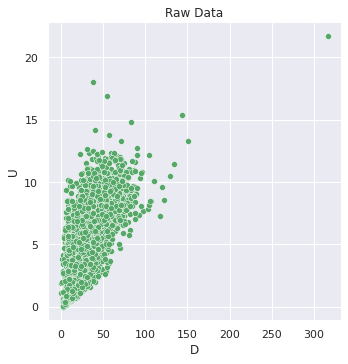

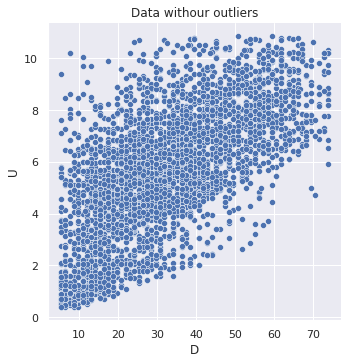

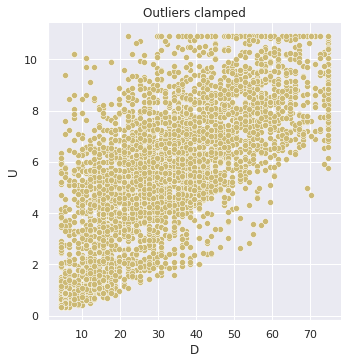

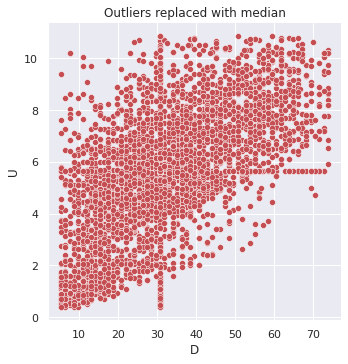

In [255]:
sns.set(font_scale=1)
r1 = sns.relplot(x=data_train['D'], y=data_train['U'], data=data_train, color='g')
r1.set(title='Raw Data')
r2 = sns.relplot(x=data_no_outliers['D'], y=data_no_outliers['U'], data=data_no_outliers)
r2.set(title='Data withour outliers')
r2 = sns.relplot(x=data_no_outliers_clamp['D'], y=data_no_outliers_clamp['U'], data=data_no_outliers_clamp, color='y')
r2.set(title='Outliers clamped')
r3 = sns.relplot(x=data_no_outliers_median['D'], y=data_no_outliers_median['U'], data=data_no_outliers_median, color='r')
r3.set(title='Outliers replaced with median');

Plot some other dependencies between a features

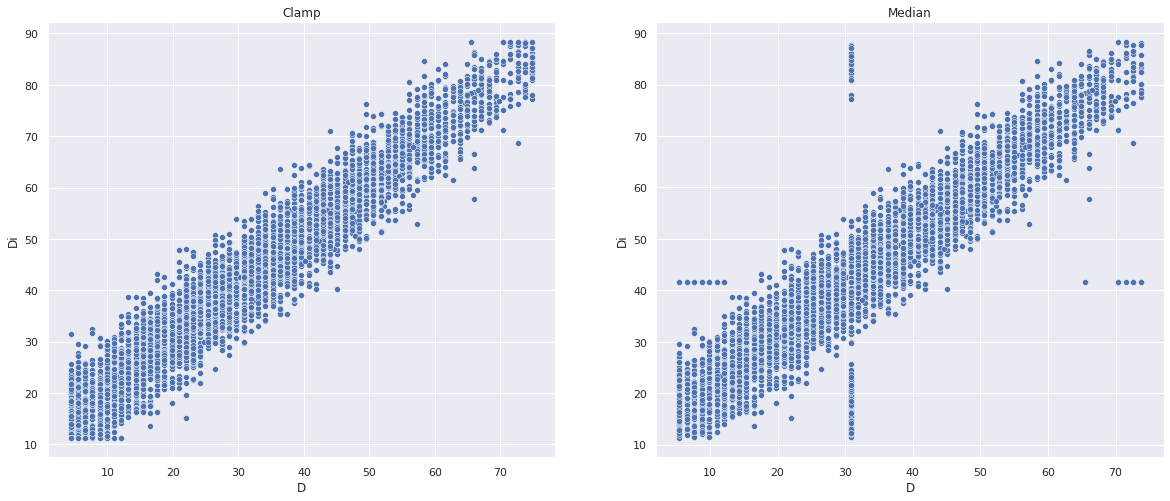

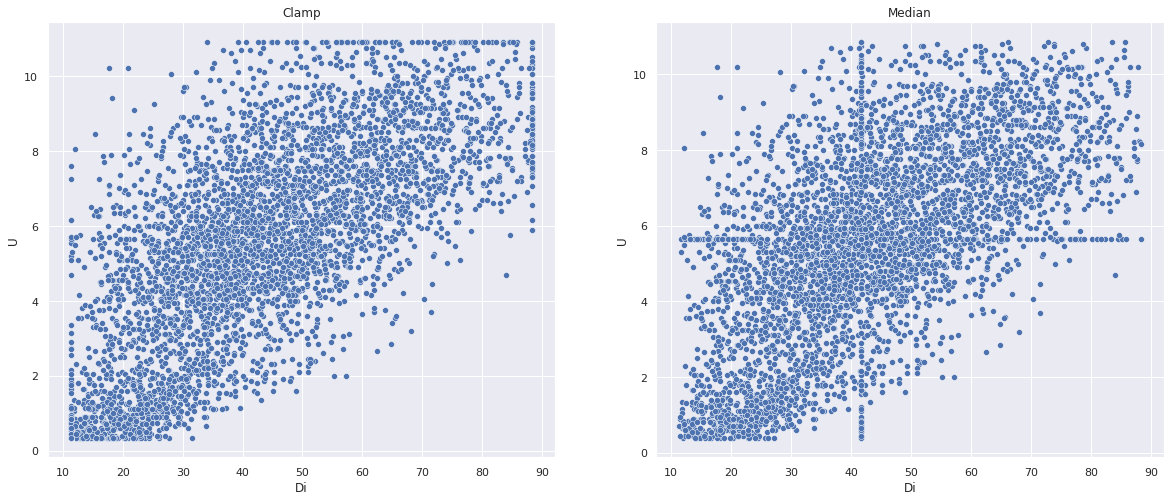

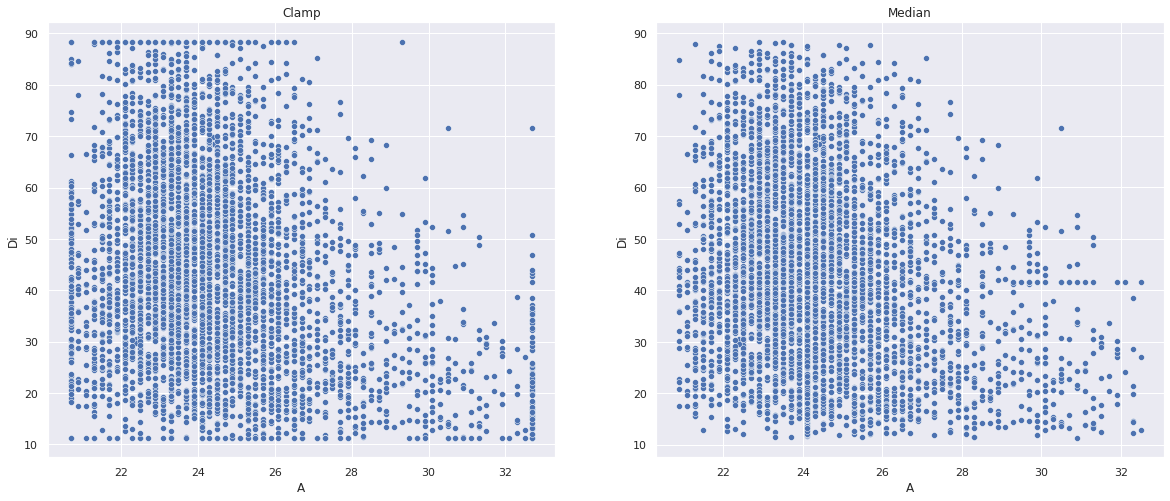

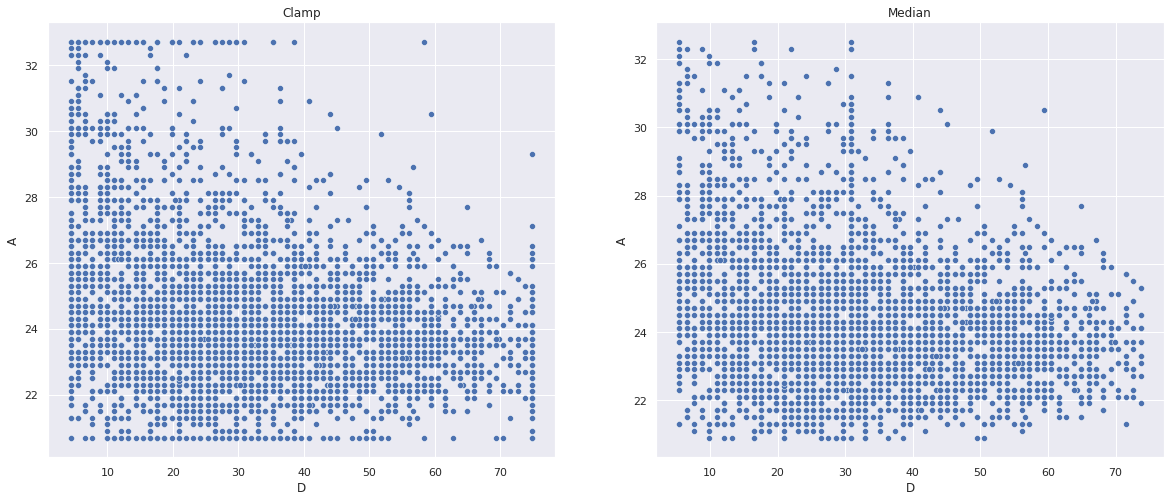

In [256]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
c1 = sns.scatterplot(data=data_no_outliers_clamp, x='D', y='Di', ax=ax1).set(title='Clamp')
m1 = sns.scatterplot(data=data_no_outliers_median, x='D', y='Di', ax=ax2).set(title='Median')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
c2 = sns.scatterplot(data=data_no_outliers_clamp, x='Di', y='U', ax=ax1).set(title='Clamp')
m2 = sns.scatterplot(data=data_no_outliers_median, x='Di', y='U', ax=ax2).set(title='Median')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
c3 = sns.scatterplot(data=data_no_outliers_clamp, x='A', y='Di', ax=ax1).set(title='Clamp')
m3 = sns.scatterplot(data=data_no_outliers_median, x='A', y='Di', ax=ax2).set(title='Median')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
c4 = sns.scatterplot(data=data_no_outliers_clamp, x='D', y='A', ax=ax1).set(title='Clamp')
m4 = sns.scatterplot(data=data_no_outliers_median, x='D', y='A', ax=ax2).set(title='Median')

Below we see how changes 'A' feature distribution from raw data to no-outliers data, clamped and replaced with median data.

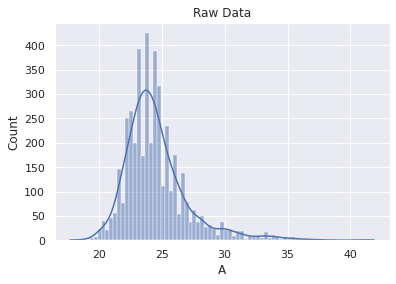

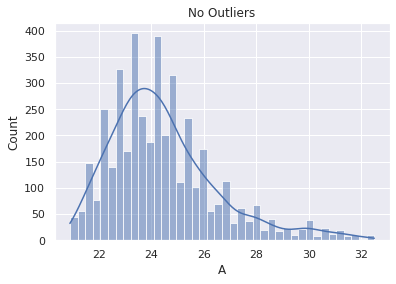

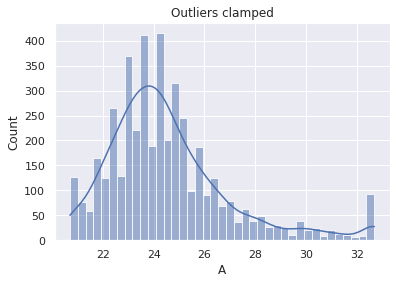

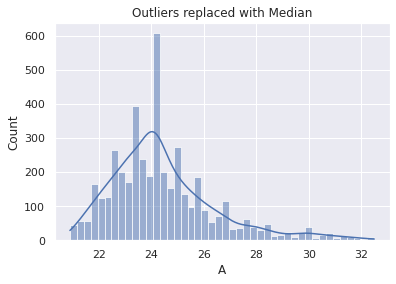

In [257]:
sns.histplot(data_train, x=data_train.A, kde=True).set(title='Raw Data');
plt.show()
sns.histplot(data_no_outliers, x=data_no_outliers.A, kde=True).set(title='No Outliers');
plt.show()
sns.histplot(data_no_outliers_clamp, x=data_no_outliers_clamp.A, kde=True).set(title='Outliers clamped');
plt.show()
sns.histplot(data_no_outliers_median, x=data_no_outliers_median.A, kde=True).set(title='Outliers replaced with Median');
plt.show()

Plot features distribution comparison for both approaches.

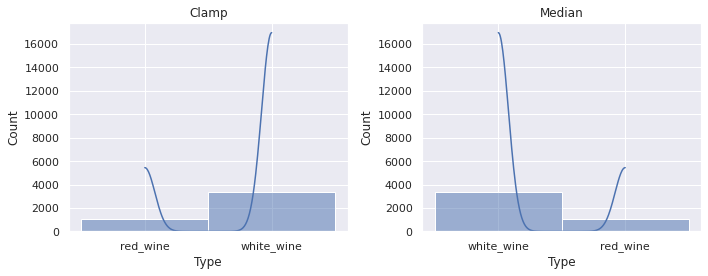

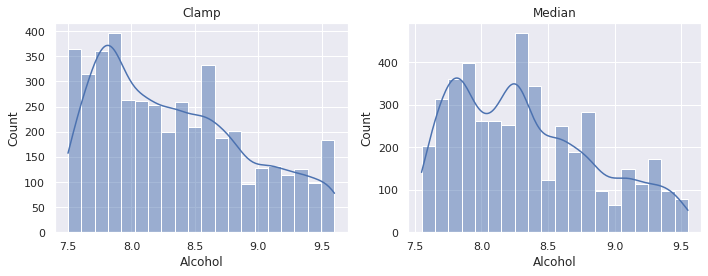

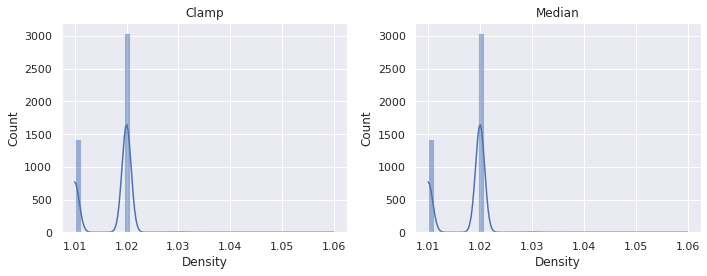

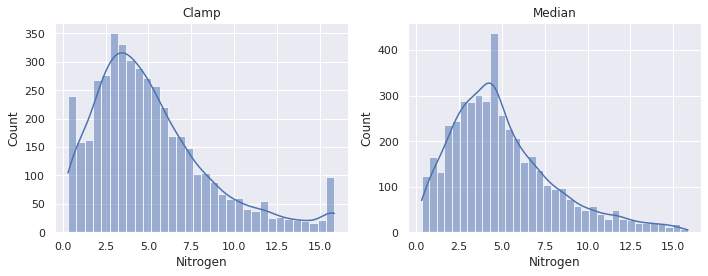

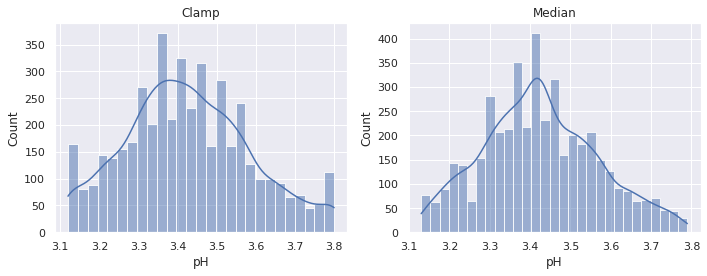

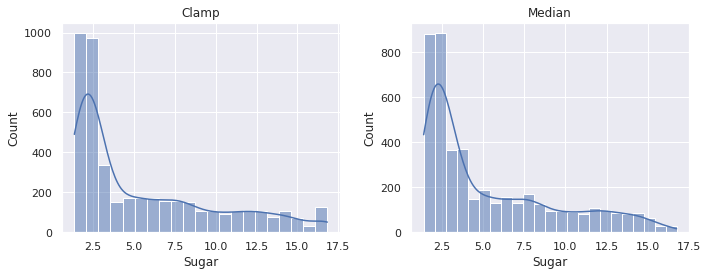

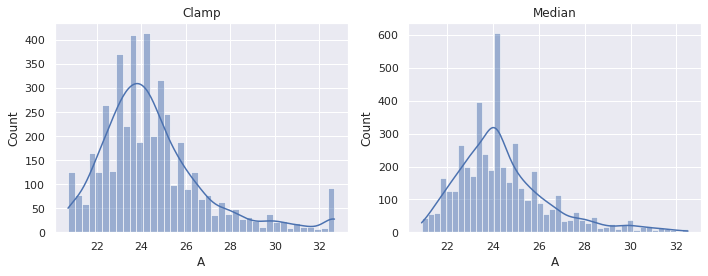

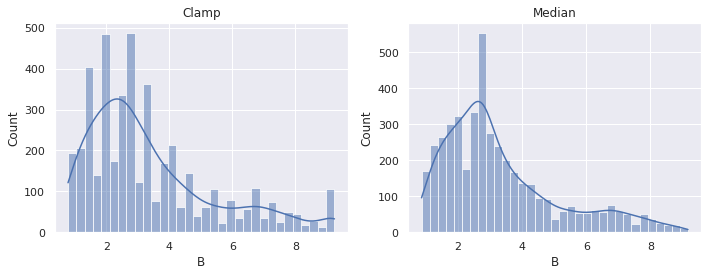

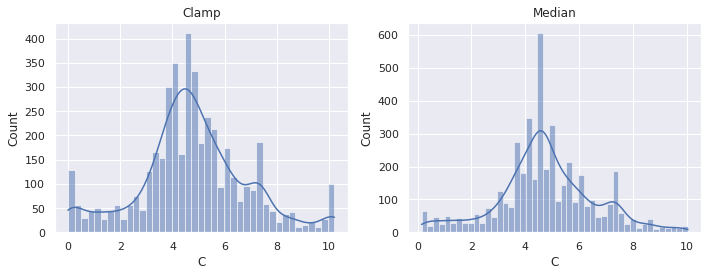

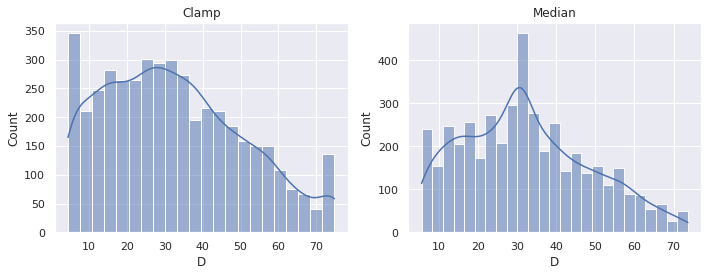

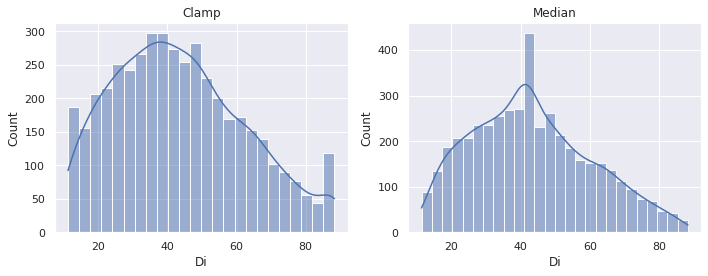

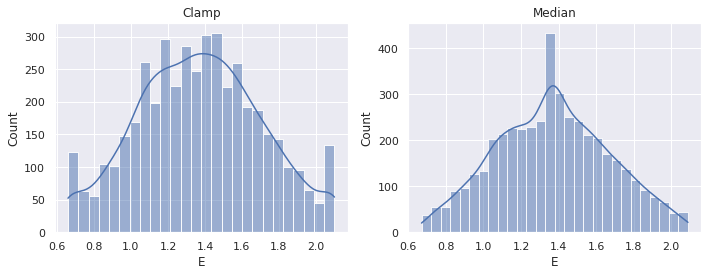

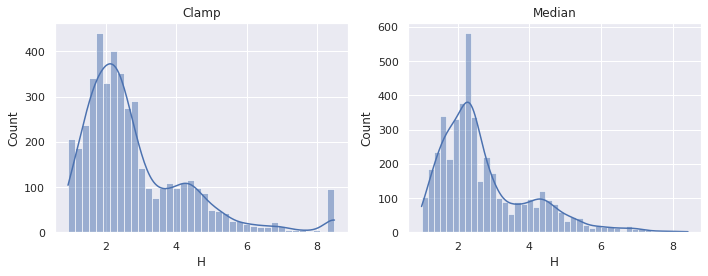

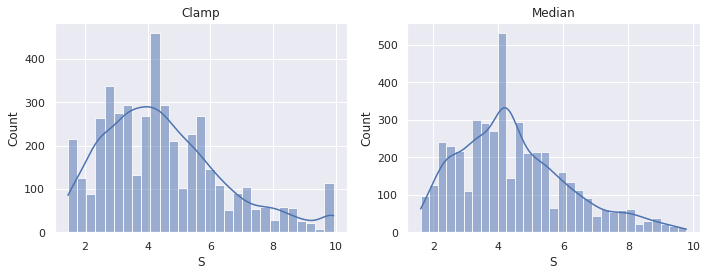

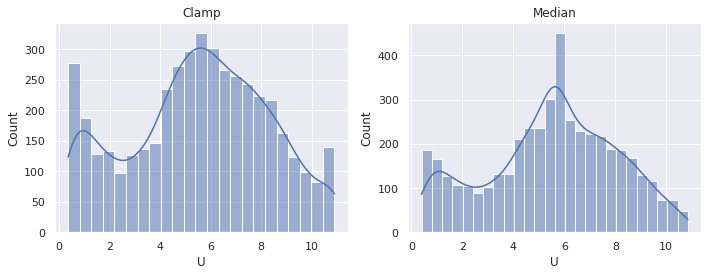

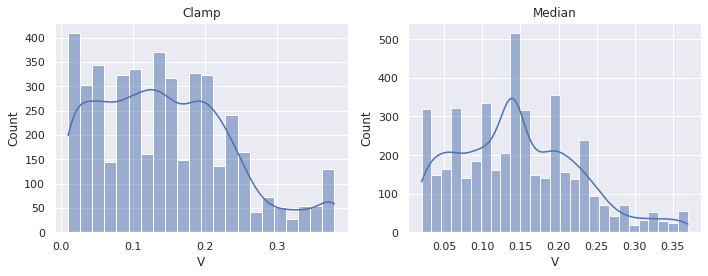

In [258]:
for feature in data_no_outliers_median.columns[1:]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(data_no_outliers_clamp, x=feature, ax=ax1, kde=True).set(title='Clamp')
    sns.histplot(data_no_outliers_median, x=feature, ax=ax2, kde=True).set(title='Median')
    plt.tight_layout()

## Advantages of each approach

As we can find on many plots, some 'crosses' and 'frames' appeared there after clamping and "medianing" (most obvious is 'D' and 'Di' plot).
It happened because we replaced outliers with median values and points were shifted to vertical and horizontal lines which lie on a median value.
'Frames' appeared because we replaced each value below and above lower and upper percentiles respectively with the relevant percentile and median 'cross' just has been pushed to the 'frame' which lies on the percentiles lines.

Watching on the distribution plot, distibution of the features that have been 'medianed' looks prettier but I concern that such a drastic change of outliers' value (from the extreme percentiles to the median) could have a negative effect on further model performance so for baseline models I will use clamped data.

## Shapiro-Wilk Test

Do the Shapiro-Wilk test firstly for clamped, then 'medianed' data to see whether any feature has normal distribution.

In [259]:
print('Clamp: ')

for column in data_no_outliers_clamp.iloc[:, 2:]:
    stat, p = shapiro(data_no_outliers_clamp[column])

    print('Column {}: Statistics = {}, p = {}'.format(column, stat, p))

    if p > 0.05:
        print('Sample DOES look Normal')
    else:
        print('Sample does NOT look Normal')

Clamp: 
Column Alcohol: Statistics = 0.9435962438583374, p = 2.4132427872206693e-38
Sample does NOT look Normal
Column Density: Statistics = 0.5945520401000977, p = 0.0
Sample does NOT look Normal
Column Nitrogen: Statistics = 0.9142202734947205, p = 8.407790785948902e-45
Sample does NOT look Normal
Column pH: Statistics = 0.9861751794815063, p = 1.513904179948704e-20
Sample does NOT look Normal
Column Sugar: Statistics = 0.8346896767616272, p = 0.0
Sample does NOT look Normal
Column A: Statistics = 0.9037355780601501, p = 0.0
Sample does NOT look Normal
Column B: Statistics = 0.8898749351501465, p = 0.0
Sample does NOT look Normal
Column C: Statistics = 0.9750044941902161, p = 2.4758755807401167e-27
Sample does NOT look Normal
Column D: Statistics = 0.9644608497619629, p = 7.442732995296327e-32
Sample does NOT look Normal
Column Di: Statistics = 0.9740879535675049, p = 8.866836056248033e-28
Sample does NOT look Normal
Column E: Statistics = 0.9910276532173157, p = 3.0441715614719313e-

In [260]:
print('Median: ')

for column in data_no_outliers_median.iloc[:, 2:]:
    stat, p = shapiro(data_no_outliers_median[column])

    print('Column {}: Statistics = {}, p = {}'.format(column, stat, p))

    if p > 0.05:
        print('Sample DOES look Normal')
    else:
        print('Sample does NOT look Normal')

Median: 
Column Alcohol: Statistics = 0.9476202726364136, p = 2.916130130229231e-37
Sample does NOT look Normal
Column Density: Statistics = 0.5945520401000977, p = 0.0
Sample does NOT look Normal
Column Nitrogen: Statistics = 0.9319309592247009, p = 3.6419747087801996e-41
Sample does NOT look Normal
Column pH: Statistics = 0.9893245100975037, p = 6.595714038551841e-18
Sample does NOT look Normal
Column Sugar: Statistics = 0.834236204624176, p = 0.0
Sample does NOT look Normal
Column A: Statistics = 0.9244785308837891, p = 9.066401064181566e-43
Sample does NOT look Normal
Column B: Statistics = 0.8920930027961731, p = 0.0
Sample does NOT look Normal
Column C: Statistics = 0.9802510142326355, p = 1.6480713412858888e-24
Sample does NOT look Normal
Column D: Statistics = 0.9722229838371277, p = 1.1921070614107072e-28
Sample does NOT look Normal
Column Di: Statistics = 0.9783311486244202, p = 1.332600540476896e-25
Sample does NOT look Normal
Column E: Statistics = 0.993013322353363, p = 5.

As we see, none of our features is normally distributed.

Plot correlation matrices.

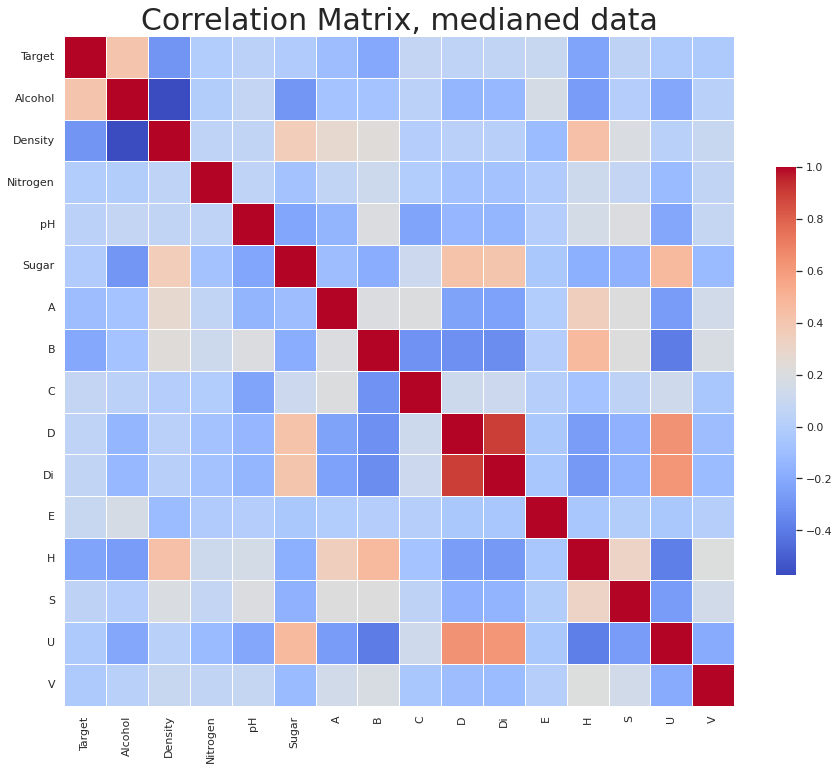

In [261]:
corr = data_no_outliers_median.corr()
f, ax = plt.subplots(figsize=(15, 15))
ax.set_title('Correlation Matrix, medianed data', fontsize=30)
sns.heatmap(corr, cmap='coolwarm', square=True, linewidths=1, cbar_kws={'shrink': .5});

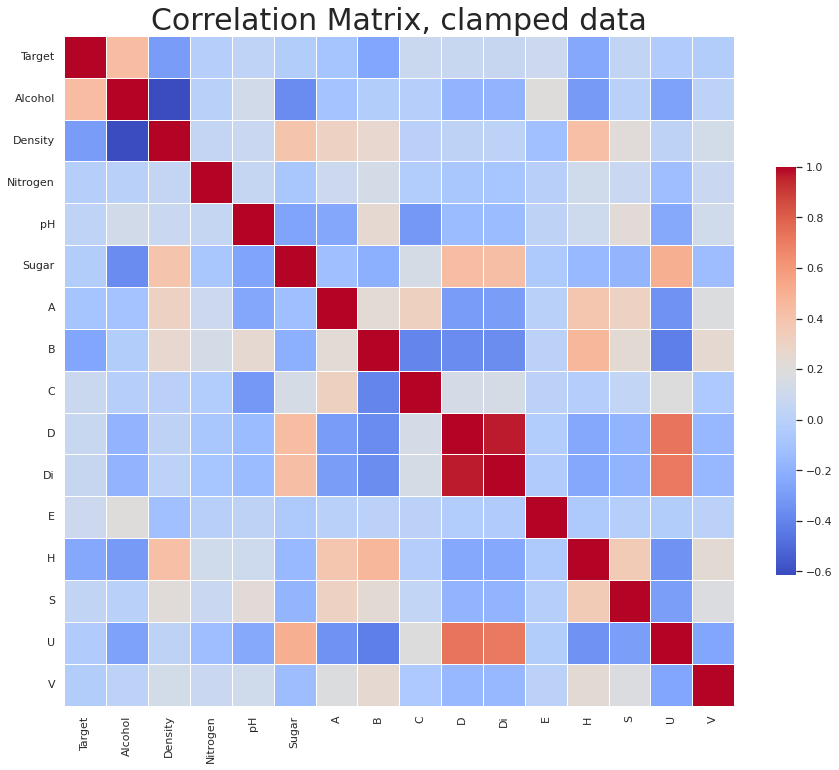

In [262]:
corr = data_no_outliers_clamp.corr()
f, ax = plt.subplots(figsize=(15, 15))
ax.set_title('Correlation Matrix, clamped data', fontsize=30)
sns.heatmap(corr, cmap='coolwarm', square=True, linewidths=1, cbar_kws={'shrink': .5});

As we see from the matrices above, two features have the strongest positive correlation: 'D' and 'Di'.
Also I would admit such pairs as 'D' and 'U'; 'Di' and 'U'.

Plot the dependency between 'D' and 'Di' features 

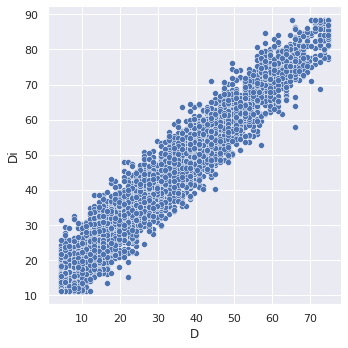

In [263]:
sns.set(font_scale=1)
sns.relplot(x=data_no_outliers_clamp['D'], y=data_no_outliers_clamp['Di'], data=data_no_outliers_clamp);

It is obvious that I can cut out one of them.
To choose which one I compute both 'D' and 'Di' variances and leave the feature with the bigger one.

In [264]:
print('Variance of ''D'': ', data_no_outliers_median['D'].var())
print('Variance of ''Di'': ', data_no_outliers_median['Di'].var())


Variance of D:  265.8992980475104
Variance of Di:  298.49759649183795


Based on this, I can drop 'D' feature.

## ANOVA Test

This and two more above tests will show us whether all features originate from the same distribution or not. Thanks to them it is possible to decide which features are not important at all so I can drop them.

In [265]:
print('ANOVA for clamped data:\n')

for column in data_no_outliers_clamp.iloc[:, 2:]:

	stat, p = f_oneway(data_no_outliers_clamp[data_no_outliers_clamp['Target'] == 1][column],
						data_no_outliers_clamp[data_no_outliers_clamp['Target'] == 2][column],
						data_no_outliers_clamp[data_no_outliers_clamp['Target'] == 3][column],
						data_no_outliers_clamp[data_no_outliers_clamp['Target'] == 4][column],
						data_no_outliers_clamp[data_no_outliers_clamp['Target'] == 5][column],
						data_no_outliers_clamp[data_no_outliers_clamp['Target'] == 6][column])

	print('Feature {}: Statistics = {}, p = {}'.format(column, stat, p))

	if p > 0.05:
		print('Looks like the same distribution')

print('\nANOVA for medianed data:\n')

for column in data_no_outliers_median.iloc[:, 2:]:

	stat1, p1 = f_oneway(data_no_outliers_median[data_no_outliers_median['Target'] == 1][column],
						data_no_outliers_median[data_no_outliers_median['Target'] == 2][column],
						data_no_outliers_median[data_no_outliers_median['Target'] == 3][column],
						data_no_outliers_median[data_no_outliers_median['Target'] == 4][column],
						data_no_outliers_median[data_no_outliers_median['Target'] == 5][column],
						data_no_outliers_median[data_no_outliers_median['Target'] == 6][column])

	print('Feature {}: Statistics = {}, p = {}'.format(column, stat1, p1))

	if p1 > 0.05:
		print('Looks like the same distribution')

ANOVA for clamped data:

Feature Alcohol: Statistics = 253.66919235919116, p = 2.7701114133016443e-239
Feature Density: Statistics = 101.2128330581766, p = 2.025829739867374e-101
Feature Nitrogen: Statistics = 1.8510698959485534, p = 0.09953924314493542
Looks like the same distribution
Feature pH: Statistics = 2.1790609596500725, p = 0.05369376084142103
Looks like the same distribution
Feature Sugar: Statistics = 6.187148362007843, p = 1.0075637481394772e-05
Feature A: Statistics = 7.889572043525911, p = 2.077902411874298e-07
Feature B: Statistics = 75.19819133759412, p = 6.970908321208567e-76
Feature C: Statistics = 7.4792125279322486, p = 5.32886515991437e-07
Feature D: Statistics = 12.15104780351377, p = 1.0208609577661839e-11
Feature Di: Statistics = 11.697324723078736, p = 2.961173492737767e-11
Feature E: Statistics = 10.514057515090824, p = 4.723518589762417e-10
Feature H: Statistics = 63.31193776544934, p = 5.227461075826818e-64
Feature S: Statistics = 2.845765951684443, p = 0.0

## Kruskal-Wallis Test

In [266]:
print('Kruskal-Wallis for clamped data:\n')

for column in data_no_outliers_clamp.iloc[:, 2:]:

	stat, p = kruskal(data_no_outliers_clamp[data_no_outliers_clamp['Target'] == 1][column],
						data_no_outliers_clamp[data_no_outliers_clamp['Target'] == 2][column],
						data_no_outliers_clamp[data_no_outliers_clamp['Target'] == 3][column],
						data_no_outliers_clamp[data_no_outliers_clamp['Target'] == 4][column],
						data_no_outliers_clamp[data_no_outliers_clamp['Target'] == 5][column],
						data_no_outliers_clamp[data_no_outliers_clamp['Target'] == 6][column])

	print('Feature {}: Statistics = {}, p = {}'.format(column, stat, p))

	if p > 0.05:
		print('Looks like the same distribution')

print('\nKruskal-Wallis for medianed data:\n')

for column in data_no_outliers_median.iloc[:, 2:]:

	stat1, p1 = kruskal(data_no_outliers_median[data_no_outliers_median['Target'] == 1][column],
						data_no_outliers_median[data_no_outliers_median['Target'] == 2][column],
						data_no_outliers_median[data_no_outliers_median['Target'] == 3][column],
						data_no_outliers_median[data_no_outliers_median['Target'] == 4][column],
						data_no_outliers_median[data_no_outliers_median['Target'] == 5][column],
						data_no_outliers_median[data_no_outliers_median['Target'] == 6][column])

	print('Feature {}: Statistics = {}, p = {}'.format(column, stat1, p1))

	if p1 > 0.05:
		print('Looks like the same distribution')

Kruskal-Wallis for clamped data:

Feature Alcohol: Statistics = 918.0652789400278, p = 3.274953991294446e-196
Feature Density: Statistics = 464.5572023772685, p = 3.5552028221996074e-98
Feature Nitrogen: Statistics = 9.096900914823506, p = 0.1052609696961682
Looks like the same distribution
Feature pH: Statistics = 11.900185371135553, p = 0.03618136610649243
Feature Sugar: Statistics = 23.075279668590913, p = 0.0003265612447239159
Feature A: Statistics = 57.984867670567226, p = 3.168155109424307e-11
Feature B: Statistics = 325.379348169844, p = 3.484769639858081e-68
Feature C: Statistics = 47.689372955677214, p = 4.110160370754398e-09
Feature D: Statistics = 79.72697303276387, p = 9.57131171558817e-16
Feature Di: Statistics = 73.59964612823237, p = 1.822851807669333e-14
Feature E: Statistics = 54.58283323858352, p = 1.5905061809696668e-10
Feature H: Statistics = 428.41889423788155, p = 2.216554701556698e-90
Feature S: Statistics = 8.098416016947278, p = 0.15089448471740816
Looks like t

## Mann-Whitney U Test

In [267]:
print('Mann-Whitney for clamped data:\n')

for column in data_no_outliers_clamp.iloc[:, 2:]:

	stat, p = mannwhitneyu(data_no_outliers_clamp[data_no_outliers_clamp['Type'] == 'white_wine'][column],
						data_no_outliers_clamp[data_no_outliers_clamp['Type'] == 'red_wine'][column])

	print('Feature {}: Statistics = {}, p = {}'.format(column, stat, p))

	if p > 0.05:
		print('Looks like the same distribution')

print('\nMann-Whitney for medianed data:\n')

for column in data_no_outliers_median.iloc[:, 2:]:

	stat1, p1 = mannwhitneyu(data_no_outliers_median[data_no_outliers_median['Type'] == 'white_wine'][column],
						data_no_outliers_median[data_no_outliers_median['Type'] == 'red_wine'][column])

	print('Feature {}: Statistics = {}, p = {}'.format(column, stat1, p1))

	if p1 > 0.05:
		print('Looks like the same distribution')

Mann-Whitney for clamped data:

Feature Alcohol: Statistics = 1865978.0, p = 0.5763859398570057
Looks like the same distribution
Feature Density: Statistics = 1135385.0, p = 7.373881467228073e-124
Feature Nitrogen: Statistics = 1391882.0, p = 2.6578084630903814e-34
Feature pH: Statistics = 1023568.0, p = 1.3392623265775984e-108
Feature Sugar: Statistics = 2494203.0, p = 1.875258710097761e-68
Feature A: Statistics = 807509.5, p = 3.728490773876326e-172
Feature B: Statistics = 365471.5, p = 0.0
Feature C: Statistics = 2267802.5, p = 4.806956595068499e-30
Feature D: Statistics = 3123412.0, p = 6.927447817709602e-260
Feature Di: Statistics = 3093021.0, p = 1.10463584687805e-247
Feature E: Statistics = 1877538.5, p = 0.38437579970540703
Looks like the same distribution
Feature H: Statistics = 206623.0, p = 0.0
Feature S: Statistics = 635519.0, p = 4.295194564177667e-233
Feature U: Statistics = 3508426.5, p = 0.0
Feature V: Statistics = 1107177.5, p = 4.545989448140948e-88

Mann-Whitney for 

I can drop all features that have p>0.05 but if we look at the correlation matrix, we can find that ‘Alcohol’ feature has the highest correlation with the target feature so it is valuable for us.
Finally, I will drop features: D, Nitrogen, V and E.

In [268]:
data_dropped = data_no_outliers_clamp.drop(['D', 'Nitrogen', 'V', 'E'], axis=1)
data_val = data_val.drop(['D', 'Nitrogen', 'V', 'E'], axis=1)

print(data_dropped.head())
print(data_val.head())

      Target        Type  Alcohol  Density    pH  Sugar     A     B     C  \
4556       4    red_wine     8.85     1.02  3.51   2.87  24.5  4.09  6.60   
2768       4  white_wine     8.55     1.02  3.43   9.90  22.3  2.24  4.20   
2692       4  white_wine     7.85     1.02  3.16   3.06  26.9  1.58  4.65   
910        4  white_wine     8.70     1.01  3.30   1.35  26.1  1.58  6.60   
5033       3  white_wine     7.80     1.02  3.52  16.83  21.5  2.64  3.60   

         Di     H     S     U  
4556  38.75  3.53  9.05  2.10  
2768  63.46  2.85  1.90  6.25  
2692  26.91  2.79  3.36  4.15  
910   44.56  2.98  1.46  5.25  
5033  74.71  2.17  3.21  8.05  
      Target        Type  Alcohol  Density    pH  Sugar     A     B     C  \
2256       4  white_wine     8.80     1.01  3.27   1.73  24.9  1.06  4.80   
5224       5  white_wine     8.55     1.02  3.32  10.09  23.5  1.32  4.20   
4283       4    red_wine     8.55     1.02  3.39   8.95  28.3  2.64  6.90   
2024       3  white_wine     8.85    

## PCA

After dropping non-important features I will do the dimensionality reduction, PCA in first.

In [27]:
# don't include categorical 'Type' feature
X = data_dropped.iloc[:, 2:]

X = StandardScaler().fit_transform(X)

After fitting, I plot the cumulative variance graph using which I can decide how many principal components to leave.

Variance ratio descending:  [0.29066685 0.21234638 0.14385598 0.08652602 0.05835813 0.05430768
 0.04492313 0.03776774 0.03057874 0.02107978 0.01958957]


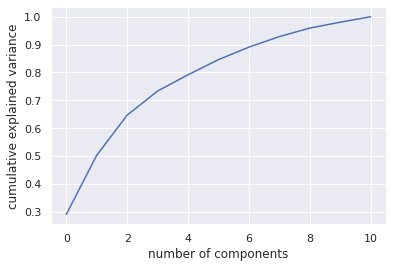

In [28]:
pca = PCA().fit(X)
# see how many exactly variance we have from each component
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print('Variance ratio descending: ', pca.explained_variance_ratio_)

Analyzing PCA results, we can see that we can use just 8 of principal components and lose only about 4% of variance. Let's do it.

In [29]:
pca = PCA(n_components=8)
principal_components = pca.fit_transform(X)

Couple of plots with Principal Components visualization by 'Target' and 'Type' features:

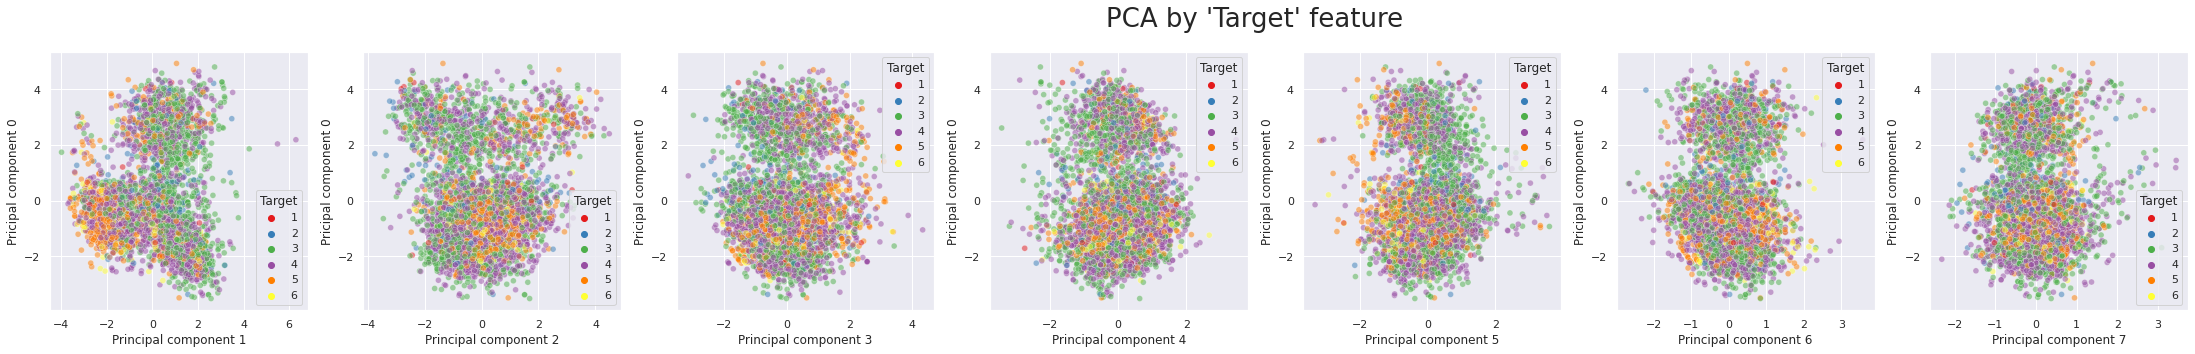

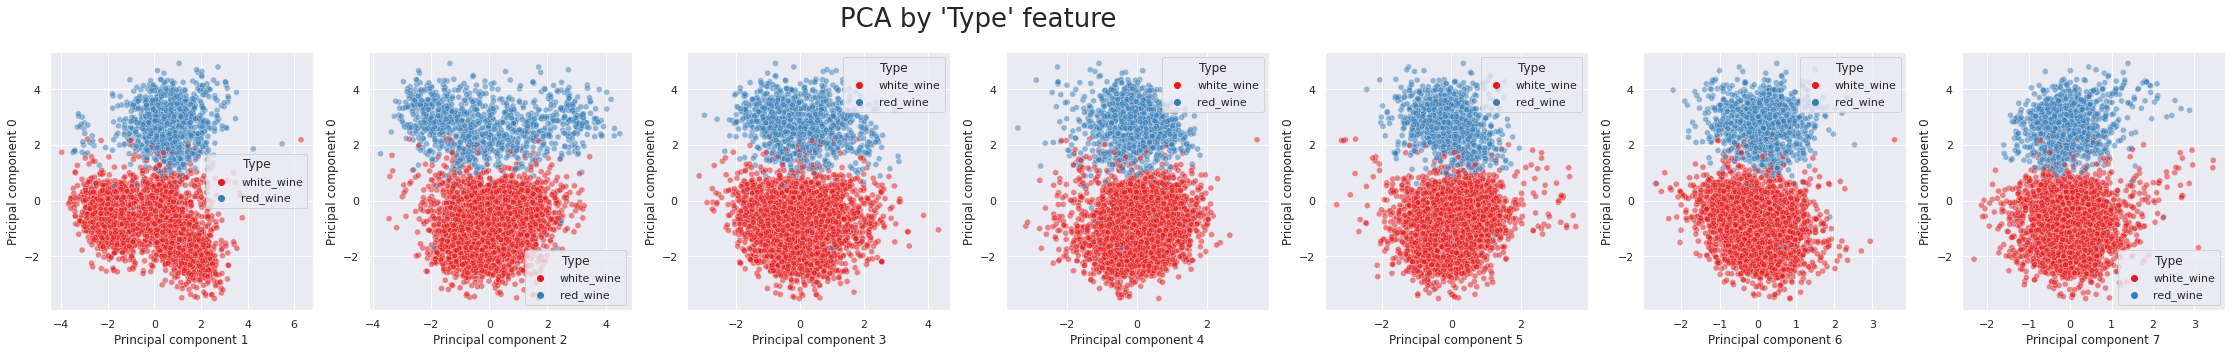

In [30]:
fig = plt.figure(figsize=(35, 5))
fig.suptitle('PCA by \'Target\' feature', fontsize=26)

for j in range(1, len(pca.explained_variance_ratio_)):
    ax = fig.add_subplot(1, 8, j)
    sns.scatterplot(x=principal_components[:, j], y=principal_components[:, 0],
                data=data_dropped['Target'],
                hue=data_dropped['Target'],
                alpha=0.5,
                palette=sns.color_palette('Set1', 6), 
                ax=ax)
    plt.xlabel('Principal component %i' %j)
    plt.ylabel('Pricipal component 0')

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(35, 5))
fig.suptitle('PCA by \'Type\' feature', fontsize=26)
for j in range(1, len(pca.explained_variance_ratio_)):
    ax = fig.add_subplot(1, 8, j+1)
    sns.scatterplot(x=principal_components[:, j], y=principal_components[:, 0],
                data=data_dropped['Type'],
                hue=data_dropped['Type'],
                alpha=0.5,
                palette=sns.color_palette('Set1', 2), 
                ax=ax)
    plt.xlabel('Principal component %i' %j)
    plt.ylabel('Pricipal component 0')
plt.tight_layout()
plt.show()

## t-SNE

t-SNE is another technique for dimensionality reduction. I will reduce components number to 2 to better see the results on 2D visualization.

In [31]:
# don't use categorical feature in the 1st column
X_tsne = data_dropped.iloc[:, 2:]
X_tsne = StandardScaler().fit_transform(X_tsne)

X_emb = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_tsne)

Plot t-SNE by 'Target' and 'Type' features.

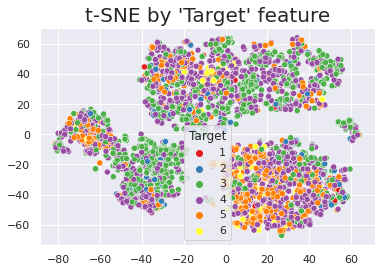

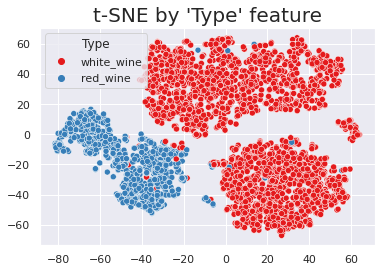

In [32]:
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], 
                hue=data_dropped['Target'], 
                legend='full', 
                palette=sns.color_palette('Set1', 6))
plt.title('t-SNE by \'Target\' feature', size=20)
plt.show();
plt.title('Seaborn heatmap - change font size')
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], 
                hue=data_dropped['Type'], 
                legend='full', 
                palette=sns.color_palette('Set1', 2))
plt.title('t-SNE by \'Type\' feature', size=20)
plt.show();

As we can see, t-SNE did a pretty decent job on our data, if sort by 'Type' feature.

## K-Means

As for the final part of EDA, I will apply K-Means algorithm to do blind clusterization on PCA-reduced data to 2 principal components, visualization and see what accuracy score we get.

In [33]:
# apply PCA before k-means to leave just 2 components
X_kmeans = data_dropped.iloc[:, 2:]
x_reduced = PCA(n_components=2).fit_transform(X_kmeans)

# apply k-means with 6 clusters
kmeans = KMeans(n_clusters=6)

# get predicted labels and centroids
y_kmeans = kmeans.fit_predict(x_reduced)
centroids = kmeans.cluster_centers_

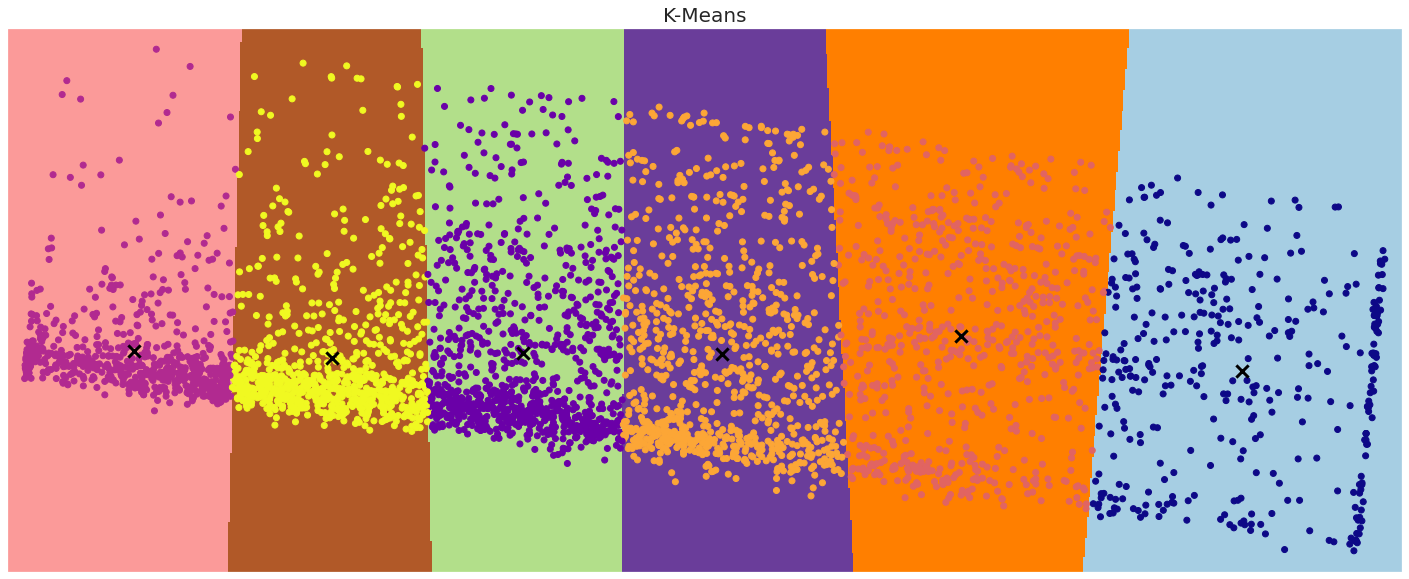

In [34]:
# set a small step size of the mesh to increase visualization quality
h = 0.1

# plot decision boundaries
x_min, x_max = x_reduced[:, 0].min() - 1, x_reduced[:, 0].max() + 1
y_min, y_max = x_reduced[:, 1].min() - 1, x_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# get labels for each point in the mesh
z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# convert result to the color plot
z = z.reshape(xx.shape)
plt.figure(1, figsize=(25,10))
plt.clf()
# plot color areas for each cluster
plt.imshow(
    z,
    interpolation='nearest',
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect='auto',
    origin='lower'
)

# plot labels by 'Target' feature
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], 
            c=y_kmeans, 
            cmap='plasma')

# plot centroids 
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker='x',
    s=150,
    linewidths=3,
    color='black',
    zorder=10
)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('K-Means', size=20)
plt.xticks(())
plt.yticks(())
plt.show()

Now let's see in details how effective K-Means was: plot Confusion Matrix and Classification report.

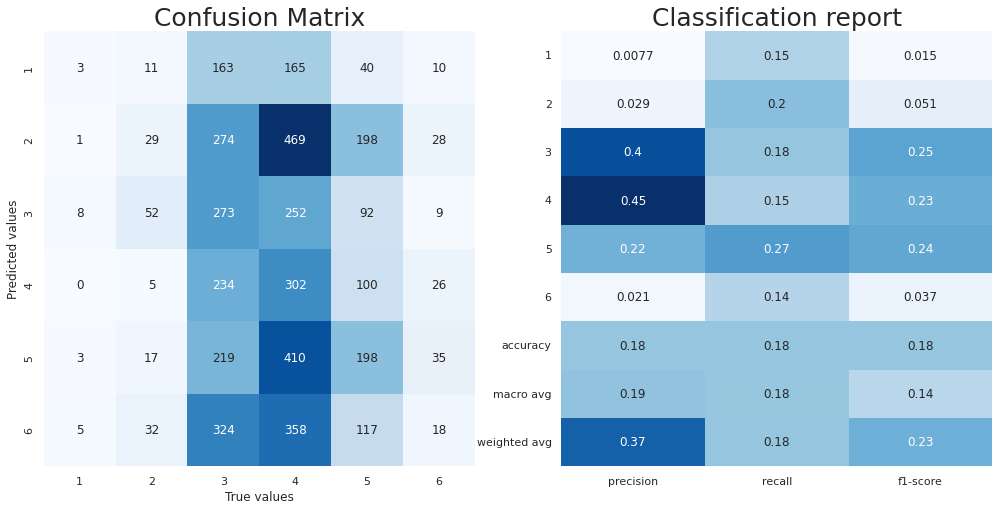

In [35]:
# get confusion matrix and classification report using standard sklearn library
# I add 1 to y_kmeans because it starts numeration with 0 and our classes start with 1
cm = confusion_matrix(data_dropped['Target'], y_kmeans+1)
cr = classification_report(data_dropped['Target'], y_kmeans+1, output_dict=True)

# plot them
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17, 8))
sns.heatmap(cm.T, annot=True, cmap='Blues', cbar=False, fmt='g', xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7), ax=ax1)
ax1.set_title('Confusion Matrix', size=25)
ax1.set_xlabel('True values')
ax1.set_ylabel('Predicted values')

sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, cmap='Blues', cbar=False, ax=ax2)
ax2.set_title('Classification report', size=25)
plt.show()

As we see from tables, we did not get much accuracy from K-Means with just 15%. But we could expect it after PCA plots with 'Target' variable: data points were distributed almost randomly with no evident clusters.


## DBSCAN

I also try the more complicated and effective clustering algorithm DBSCAN.  

It has 2 main parameters that we can tune: *epsilon* (maximum distance between 2 points to be considered as neighbors) and *min_samples* (number of samples in a neighborhood for a point to be considered as a core point).  

To find optimal epsilon parameter value for DBSCAN I should plot the K-distance Graph. For the K-distance Graph, in turn, I should obtain the distances between each point in dataset and the nearest point to them. I can get them using NearestNeighbors from sklearn.neighbors.

In [36]:
X_dbscan = data_dropped.iloc[:, 2:]
X_dbscan = StandardScaler().fit_transform(X_dbscan)
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_dbscan)
distances, indices = nbrs.kneighbors(X_dbscan)

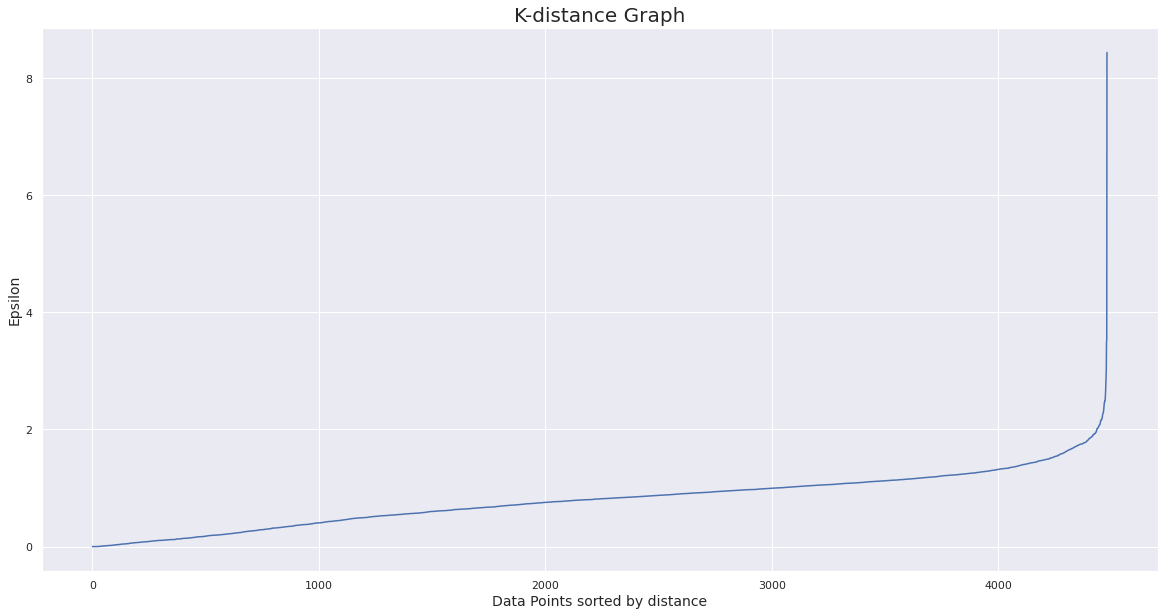

In [37]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

Then, I should choose the according value on Y scale where graph has the maximum curvature. As seen on the plot, optimal epsilon would be equal to about 1.9.  
I decided to leave 'min_samples' with default value, 5. 

In [269]:
clustering = DBSCAN(eps=1.9, min_samples=5).fit(X)
labels = clustering.labels_

print(np.unique(labels))

[-1  0  1  2  3  4]


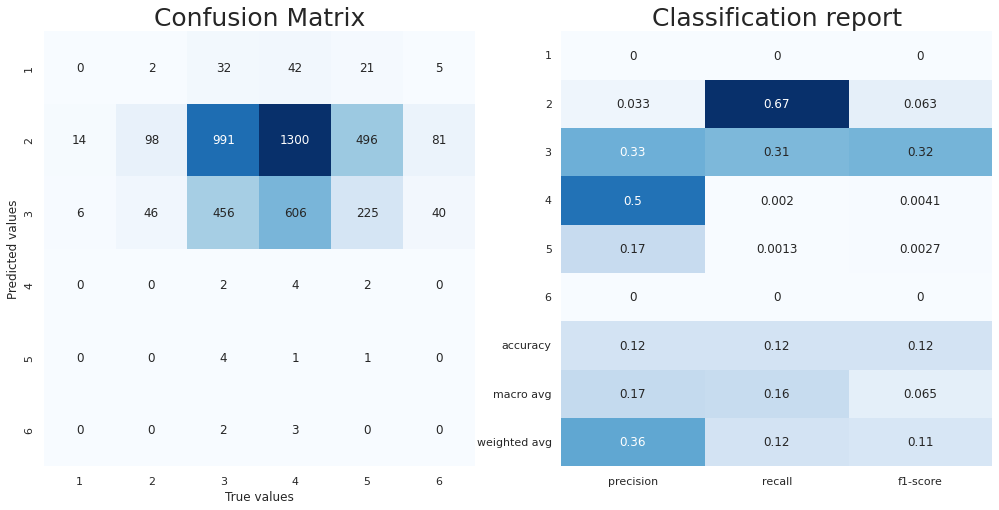

In [270]:
# get confusion matrix and classification report using standard sklearn library
# add 2 to labels number since they start from -1 and we need 1-6
cm = confusion_matrix(data_dropped['Target'], labels+2)
cr = classification_report(data_dropped['Target'], labels+2, output_dict=True)

# plot them
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17, 8))
sns.heatmap(cm.T, annot=True, cmap='Blues', cbar=False, fmt='g', xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7), ax=ax1)
ax1.set_title('Confusion Matrix', size=25)
ax1.set_xlabel('True values')
ax1.set_ylabel('Predicted values')

sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, cmap='Blues', cbar=False, ax=ax2)
ax2.set_title('Classification report', size=25)
plt.show()

# Modeling

I need a baseline to compare model efficiency so I will apply some basic models without tuning any hyperparameters:
- logistic regression
- gradient boosting
- naive bayes
- decision tree
- random forest

But firstly I should get rid of categorical data and replace it with dummy variable.

In [40]:
# handle dummy features
data_dropped2 = pd.get_dummies(data=data_dropped, drop_first=True)
data_val2 = pd.get_dummies(data=data_val, drop_first=True)

# handle NaNs: replace with median for numerical features and with most popular class for the 'Type' column
data_val2.iloc[:, 2:] = data_val2.iloc[:, 2:].fillna(data_val2.median())
data_val2.iloc[:, 1] = data_val2.iloc[:, 1].fillna('white_wine')
print('Are there any NaNs left?', data_val2.isnull().values.any())

Are there any NaNs left? False


In [41]:
x_train = data_dropped2.iloc[:, 1:]
y_train = data_dropped2.iloc[:, 0]
x_val = data_val2.iloc[:, 1:]
y_val = data_val2.iloc[:, 0]

Do the label encoding since the Target column is numerical and categorical is needed for the classification models.

In [42]:
le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_val_enc = le.fit_transform(y_val)

In [43]:
# prepare dictionary for models' scores
scores = {}

## Logistic regression

For first, I will use the simplest Linear Regression to have some base to compare model scores.

Firstly, I should do the standardization because it will affect on Logistic regression converging time drastically.

In [44]:
x_train_scaled = StandardScaler().fit_transform(x_train)
x_val_scaled = StandardScaler().fit_transform(x_val)

In [162]:
# set such max_iter to have model converging
clf = LogisticRegression(max_iter=200)

clf.fit(x_train_scaled, y_train_enc)

LogisticRegression(max_iter=200)

In [163]:
y_pred_lr = clf.predict(x_val_scaled)

scores['Logistic'] = accuracy_score(y_val_enc, y_pred_lr)

print('Accuracy for logistic regression is', scores['Logistic'])

Accuracy for logistic regression is 0.5321428571428571


## Boosting

In [47]:
boost = GradientBoostingClassifier().fit(x_train, y_train_enc)

In [48]:
y_pred_boost = boost.predict(x_val)

scores['Boosting'] = boost.score(x_val, y_val_enc)

print('Accuracy for boosting is', scores['Boosting'])

Accuracy for boosting is 0.5982142857142857


## Naїve Bayes

In [49]:
bayes = ComplementNB().fit(x_train, y_train_enc)

In [50]:
y_pred_bayes = bayes.predict(x_val)

scores['Bayes'] = bayes.score(x_val, y_val_enc)

print('Accuracy for Bayes is', scores['Bayes'])

Accuracy for Bayes is 0.41785714285714287


## Decision Tree

In [51]:
dt = DecisionTreeClassifier().fit(x_train, y_train_enc)

In [52]:
y_pred_dt = dt.predict(x_val)

scores['Decision_tree'] = dt.score(x_val, y_val_enc)

print('Accuracy for Decision Tree:', scores['Decision_tree'])

Accuracy for Decision Tree: 0.575


## Random Forest

In [53]:
rf = RandomForestClassifier()

rf.fit(x_train, y_train_enc)

RandomForestClassifier()

In [54]:
y_pred_rf = rf.predict(x_val)

scores['Random_forest'] = rf.score(x_val, y_val_enc)

print('Accuracy for Random Forest:', scores['Random_forest'])

Accuracy for Random Forest: 0.6714285714285714


Raw untuned models performance:

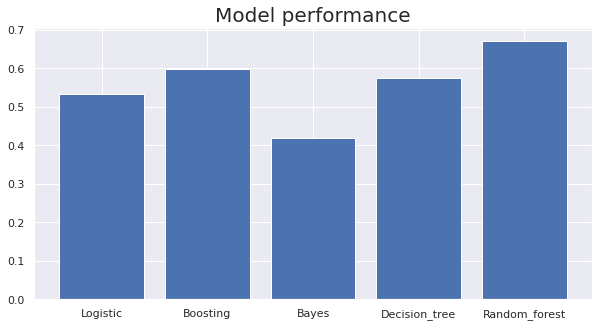

In [55]:
plt.figure(figsize=(10, 5))
plt.title('Model performance', fontdict={'fontsize': 20})
plt.bar([key for key in scores], scores.values())
plt.show()

## Confusion Matrices

Below I plot confusion matrices with prediction of all 5 algorithms.
I can use them to analyse which classes are hard to predict for models and which are not.

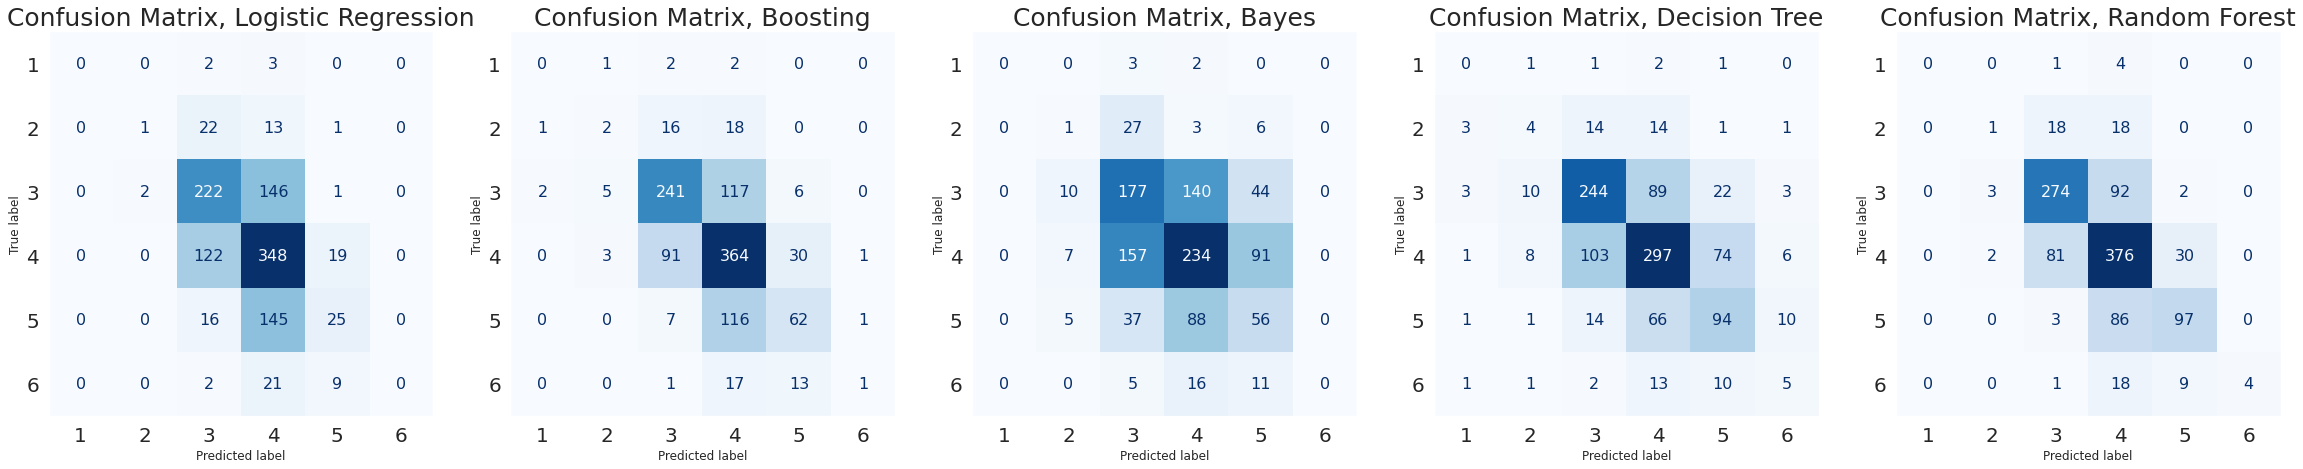

In [167]:
# get all confusion matrices
cm_lr = confusion_matrix(y_val_enc, y_pred_lr, labels=clf.classes_)
cm_boost = confusion_matrix(y_val_enc, y_pred_boost, labels=boost.classes_)
cm_bayes = confusion_matrix(y_val_enc, y_pred_bayes, labels=bayes.classes_)
cm_dt = confusion_matrix(y_val_enc, y_pred_dt, labels=dt.classes_)
cm_rf = confusion_matrix(y_val_enc, y_pred_rf, labels=rf.classes_)

c_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=clf.classes_+1)
c_boost = ConfusionMatrixDisplay(confusion_matrix=cm_boost, display_labels=boost.classes_+1)
c_bayes = ConfusionMatrixDisplay(confusion_matrix=cm_bayes, display_labels=bayes.classes_+1)
c_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=dt.classes_+1)
c_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf.classes_+1)

# plot them
plt.rcParams['axes.grid'] = False

_, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(40, 8))
plt.rcParams.update({'font.size': 16})

c_lr.plot(cmap='Blues', colorbar=False, ax=ax1)
ax1.set_title('Confusion Matrix, Logistic Regression', size=25)
ax1.tick_params(labelsize=20)

c_boost.plot(cmap='Blues', colorbar=False, ax=ax2)
ax2.set_title('Confusion Matrix, Boosting', size=25)
ax2.tick_params(labelsize=20)

c_bayes.plot(cmap='Blues', colorbar=False, ax=ax3)
ax3.set_title('Confusion Matrix, Bayes', size=25)
ax3.tick_params(labelsize=20)

c_dt.plot(cmap='Blues', colorbar=False, ax=ax4)
ax4.set_title('Confusion Matrix, Decision Tree', size=25)
ax4.tick_params(labelsize=20)

c_rf.plot(cmap='Blues', colorbar=False, ax=ax5)
ax5.set_title('Confusion Matrix, Random Forest', size=25)
ax5.tick_params(labelsize=20)
plt.show()

## Cross-Validation

Do the cross-validation for all 5 algorithms to evaluate all mean accuracies and standard deviations for each of them.

In [57]:
scores_lr = cross_val_score(clf, x_train_scaled, y_train_enc)
scores_boost = cross_val_score(boost, x_train, y_train_enc)
scores_bayes = cross_val_score(bayes, x_train, y_train_enc)
scores_tree = cross_val_score(dt, x_train, y_train_enc)
scores_rf = cross_val_score(rf, x_train, y_train_enc)

print('Scores for cross-val Logistic regression: {}\n {} mean accuracy with a standard deviation of {}\n'.format(scores_lr, scores_lr.mean(), scores_lr.std()))
print('Scores for cross-val Boosting: {}\n {} mean accuracy with a standard deviation of {}\n'.format(scores_boost, scores_boost.mean(), scores_boost.std()))
print('Scores for cross-val Naive Bayes: {}\n {} mean accuracy with a standard deviation of {}\n'.format(scores_bayes, scores_bayes.mean(), scores_bayes.std()))
print('Scores for cross-val Decision Tree: {}\n {} mean accuracy with a standard deviation of {}\n'.format(scores_tree, scores_tree.mean(), scores_tree.std()))
print('Scores for cross-val Random forest: {}\n {} mean accuracy with a standard deviation of {}\n'.format(scores_rf, scores_rf.mean(), scores_rf.std()))


Scores for cross-val Logistic regression: [0.56808036 0.53683036 0.53571429 0.52008929 0.54575893]
 0.5412946428571429 mean accuracy with a standard deviation of 0.015736211367870144

Scores for cross-val Boosting: [0.58816964 0.59263393 0.57366071 0.57924107 0.55803571]
 0.5783482142857144 mean accuracy with a standard deviation of 0.0121318555729475

Scores for cross-val Naive Bayes: [0.4453125  0.42857143 0.42857143 0.38616071 0.40625   ]
 0.4189732142857143 mean accuracy with a standard deviation of 0.020574497538933766

Scores for cross-val Decision Tree: [0.52455357 0.53794643 0.53794643 0.52678571 0.52120536]
 0.5296875 mean accuracy with a standard deviation of 0.006973437210630971

Scores for cross-val Random forest: [0.64397321 0.64620536 0.63950893 0.63504464 0.62946429]
 0.6388392857142857 mean accuracy with a standard deviation of 0.006055651770647551



## Feature Importances

Get feature importances from 3 different sources: output attributes of the Logistic Regression and Decision Tree and Sklearn method ‘permutation_importance’ with the Random Forest model as estimator.

In [87]:
# sklearn built-in method using random forest classifier
perm_importance = permutation_importance(rf, x_val, y_val_enc)
# importance from logistic regression
importance_logreg = clf.coef_[0]
# importance from decision tree
importance_dt = dt.feature_importances_
# get column names
feature_names = data_dropped.columns[1:]

Plot the results.

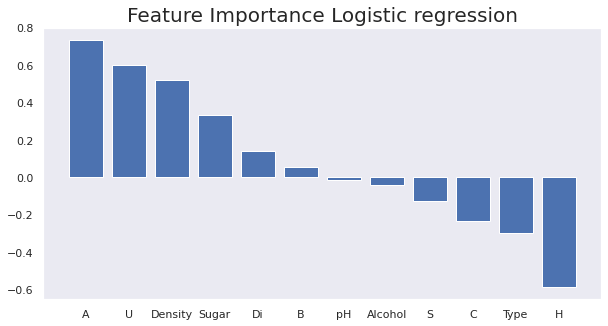

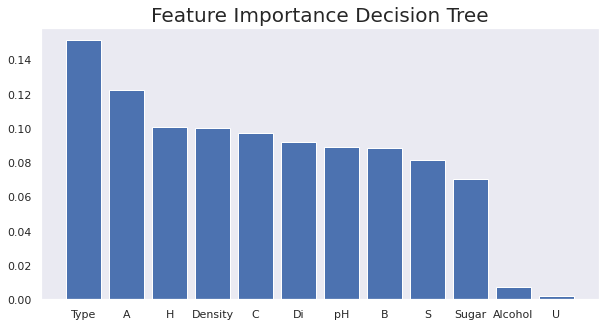

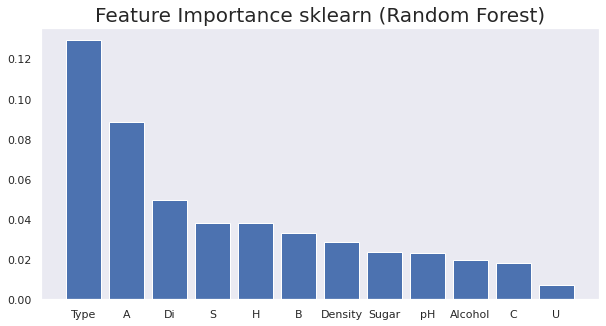

In [90]:
sorted_idx = (-importance_logreg).argsort()
plt.figure(figsize=(10, 5))
plt.title('Feature Importance Logistic regression', fontdict={'fontsize': 20})
plt.bar(feature_names[sorted_idx], importance_logreg[sorted_idx])
plt.show()

sorted_idx = (-importance_dt).argsort()
plt.figure(figsize=(10, 5))
plt.title('Feature Importance Decision Tree', fontdict={'fontsize': 20})
plt.bar(feature_names[sorted_idx], importance_dt[sorted_idx])
plt.show()

sorted_idx = (-perm_importance.importances_mean).argsort()
plt.figure(figsize=(10, 5))
plt.title('Feature Importance sklearn (Random Forest)', fontdict={'fontsize': 20})
plt.bar(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.show()

Do data logarithmization and Shapiro-Wilk test one more time hoping to get normal distribution for more features.

In [157]:
# don't include the last column since it has bool values and will give us infinity after lognorm
x_train_log = np.log(x_train.iloc[:, :-1])
# return categorical column
x_train_log.insert(len(x_train_log.columns), 'Type_white_wine', x_train.loc[:, 'Type_white_wine'])

Shapiro-Wilk test for lognorm data:

In [172]:
for column in x_train_log:
    stat, p = shapiro(x_train_log[column])
    if p > 0.05:
        print('Column {}: Statistics = {}, p = {}'.format(column, stat, p))
        print('Sample does look Normal')

Column C: Statistics = nan, p = 1.0
Sample does look Normal


As we can see, log normalization of data did not give us mych results so there is no need to do Naive Bayes one more time.